In [1]:
import sys, os, pygmt, importlib, re
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor
from datetime                   import timedelta, date, datetime
from pathlib                    import Path
from dask.distributed           import Client, LocalCluster
import numpy                    as np
import pandas                   as pd
import xarray                   as xr
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
# import xesmf                    as xe
# import matplotlib.pyplot        as plt
# import matplotlib.dates         as mdates

In [64]:
# Import module *objects* first
import sea_ice_processor
import sea_ice_plotter
import grounded_iceberg_processor
# Reload them if they were edited
importlib.reload(sea_ice_processor)
importlib.reload(sea_ice_plotter)
importlib.reload(grounded_iceberg_processor)
# Then (re)import the classes from the reloaded modules
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor

# grounded icebergs

In [ ]:
GI_proc = GroundedIcebergProcessor()
GI_proc.process_raw_grounded_iceberg_database()
GI_proc.modify_landmask_with_grounded_icebergs(p_min=0.1, p_max=0.9, scaling_exponent=.35)

In [ ]:
GI_proc.write_modified_landmask_and_counts_to_disk(write=True, overwrite=True)

In [ ]:
SP = SeaIcePlotter(ice_type='GI', sim_name='baseline', show_fig = True, save_fig = True, )
KMT1 = xr.open_dataset("/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50_POSSIBLE_ERROR.nc")
KMT2 = xr.open_dataset("/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50.nc")
SP.plot_sectors_grounded_icebergs(KMT2=KMT2,save_dir="0p25", filename_extras="POSSIBLE-ERRORS_v_Revised")

In [ ]:
P_kmt_mod = "/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50.nc"
P_kmt_org = "/g/data/gv90/da1339/grounded_icebergs/MyThin_db/KMT_original_reformatted_with_coordinates.nc"
ds_mod    = xr.open_dataset(P_kmt_mod)
ds_org    = xr.open_dataset(P_kmt_org)
kmt_mod   = ds_mod['kmt'].values
kmt_org   = ds_org['kmt'].values
lat       = ds_mod['lat']
lon       = ds_mod['lon']
dlon      = np.mean(np.diff(lon.values[0]))  # assumes regular grid in ni dimension
print("MOD KMT LAND CELL COUNT:", np.sum(kmt_mod == 1))
print("ORG KMT LAND CELL COUNT:", np.sum(kmt_org == 1))
print("Total mismatches:", np.sum(kmt_mod != kmt_org))
print("Unique values in KMT MODIFIED:", np.unique(kmt_mod))
print("Unique values in KMT ORIGINAL:", np.unique(kmt_org))
assert kmt_mod.shape == kmt_org.shape == lat.shape == lon.shape
# Get indices of mismatch
mask_diff = (kmt_org==1) & (kmt_mod!=1)
ji_diff = np.where(mask_diff)  # ji_diff = (j indices, i indices)
# Shift i (longitude) index one cell west
j_idx, i_idx = ji_diff
i_idx_shifted = i_idx - 1  # move one cell west
# Remove invalid (negative) i indices
valid_mask = i_idx_shifted >= 0
j_idx = j_idx[valid_mask]
i_idx = i_idx_shifted[valid_mask]
# Extract adjusted coordinates
lat_diff = lat.values[j_idx, i_idx]
lon_diff = lon.values[j_idx, i_idx]

In [ ]:
KMT_mod = 

# process for fast ice using SeaIceProcessor()

In [ ]:
cluster = LocalCluster(n_workers=28, threads_per_worker=1, memory_limit='6GB')
client = Client(cluster)
print("✅ Dask dashboard:", client.dashboard_link)

In [ ]:
sim_name        = "elps-min"
dt0_str         = "1993-01-01"
dtN_str         = "1994-12-31"
ispd_thresh     = 5.0e-4
ice_type        = "FI_BT"
ispd_str        = f"{ispd_thresh:.1e}".replace("e-0", "e-")
smooth_FIA_days = 15
overwrite_zarr  = False
overwrite_png   = True
SI_proc  = SeaIceProcessor(sim_name = sim_name,
                           dt0_str  = dt0_str,
                           dtN_str  = dtN_str)
for itype in [ice_type]:
    SI_proc.sea_ice_metrics_wrapper(sim_name       = sim_name,
                                     ice_type       = itype,
                                     ispd_thresh    = ispd_thresh,
                                     overwrite_zarr = overwrite_zarr,
                                     overwrite_png  = overwrite_png)
#SI_proc.create_AF2020_FI_zarr()

In [65]:
sim_name        = "elps-min"
dt0_str         = "2000-01-01"
dtN_str         = "2018-12-31"
ispd_thresh     = 5.0e-4
ice_type        = "FI_BT"
ispd_str        = f"{ispd_thresh:.1e}".replace("e-0", "e-")
smooth_FIA_days = 15
overwrite_zarr  = False
overwrite_png   = True
SI_proc         = SeaIceProcessor(sim_name = sim_name,
                                  dt0_str  = dt0_str,
                                  dtN_str  = dtN_str)
FI_OBS = SI_proc.filter_AF2020_FI_by_date(dt0_str, dtN_str)
FIP_obs = SI_proc.compute_variable_aggregate(FI_OBS["FI"], time_coord_name='t_FI_obs')
FIP_obs_masked = FIP_obs.where(SI_proc.GI_proc.G_t.kmt_org == 1)

2025-06-04 10:03:04,482 - INFO - hemisphere initialised: south
INFO:elps-min:hemisphere initialised: south
2025-06-04 10:03:04,494 - INFO - Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
INFO:elps-min:Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
2025-06-04 10:03:04,495 - INFO - Median grid cell length below -60°: 10365.7 m
INFO:elps-min:Median grid cell length below -60°: 10365.7 m
2025-06-04 10:03:04,497 - INFO - → Displacement                             = 0.42% of grid cell per day
INFO:elps-min:→ Displacement                             = 0.42% of grid cell per day
2025-06-04 10:03:04,498 - INFO - → Days to fully traverse one grid cell     : 239.95 days
INFO:elps-min:→ Days to fully traverse one grid cell     : 239.95 days


583 circumpolar grounded icebergs associated with elps-min
66791608021.64 m^2 total circumpolar grounded iceberg area for elps-min


2025-06-04 10:03:05,316 - INFO - define model grid
INFO:elps-min:define model grid
2025-06-04 10:03:05,320 - INFO - defining AF2020 regridder weights
INFO:elps-min:defining AF2020 regridder weights
2025-06-04 10:03:05,322 - INFO - convert 'AF_FI_OBS_2020db' Cartesian coordinates to spherical coordindates
INFO:elps-min:convert 'AF_FI_OBS_2020db' Cartesian coordinates to spherical coordindates
2025-06-04 10:03:20,601 - INFO - Model lon: 8.490682068895694e-05 to 359.9996411456389
INFO:elps-min:Model lon: 8.490682068895694e-05 to 359.9996411456389
2025-06-04 10:03:20,642 - INFO - Obs lon:   0.011050636761467558 to 359.9862402280046
INFO:elps-min:Obs lon:   0.011050636761467558 to 359.9862402280046
2025-06-04 10:03:20,644 - INFO - 🔁 Reusing regrid weights: /g/data/gv90/da1339/grids/weights/AF_FI_2020db_to_AOM2-0p25_Tgrid.nc
INFO:elps-min:🔁 Reusing regrid weights: /g/data/gv90/da1339/grids/weights/AF_FI_2020db_to_AOM2-0p25_Tgrid.nc
2025-06-04 10:03:20,943 - INFO - *** Regridding 'AF_FI_OBS_2

ValueError: conflicting sizes for dimension 'nj': length 1080 on 'obs_lon' and length 158 on {'t_FI_obs': 'FI', 'nj': 'FI', 'ni': 'FI'}

In [ ]:
print(FIP_obs_masked.max())

INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/AF20/DML/FIP/FIP_2000-2018.png


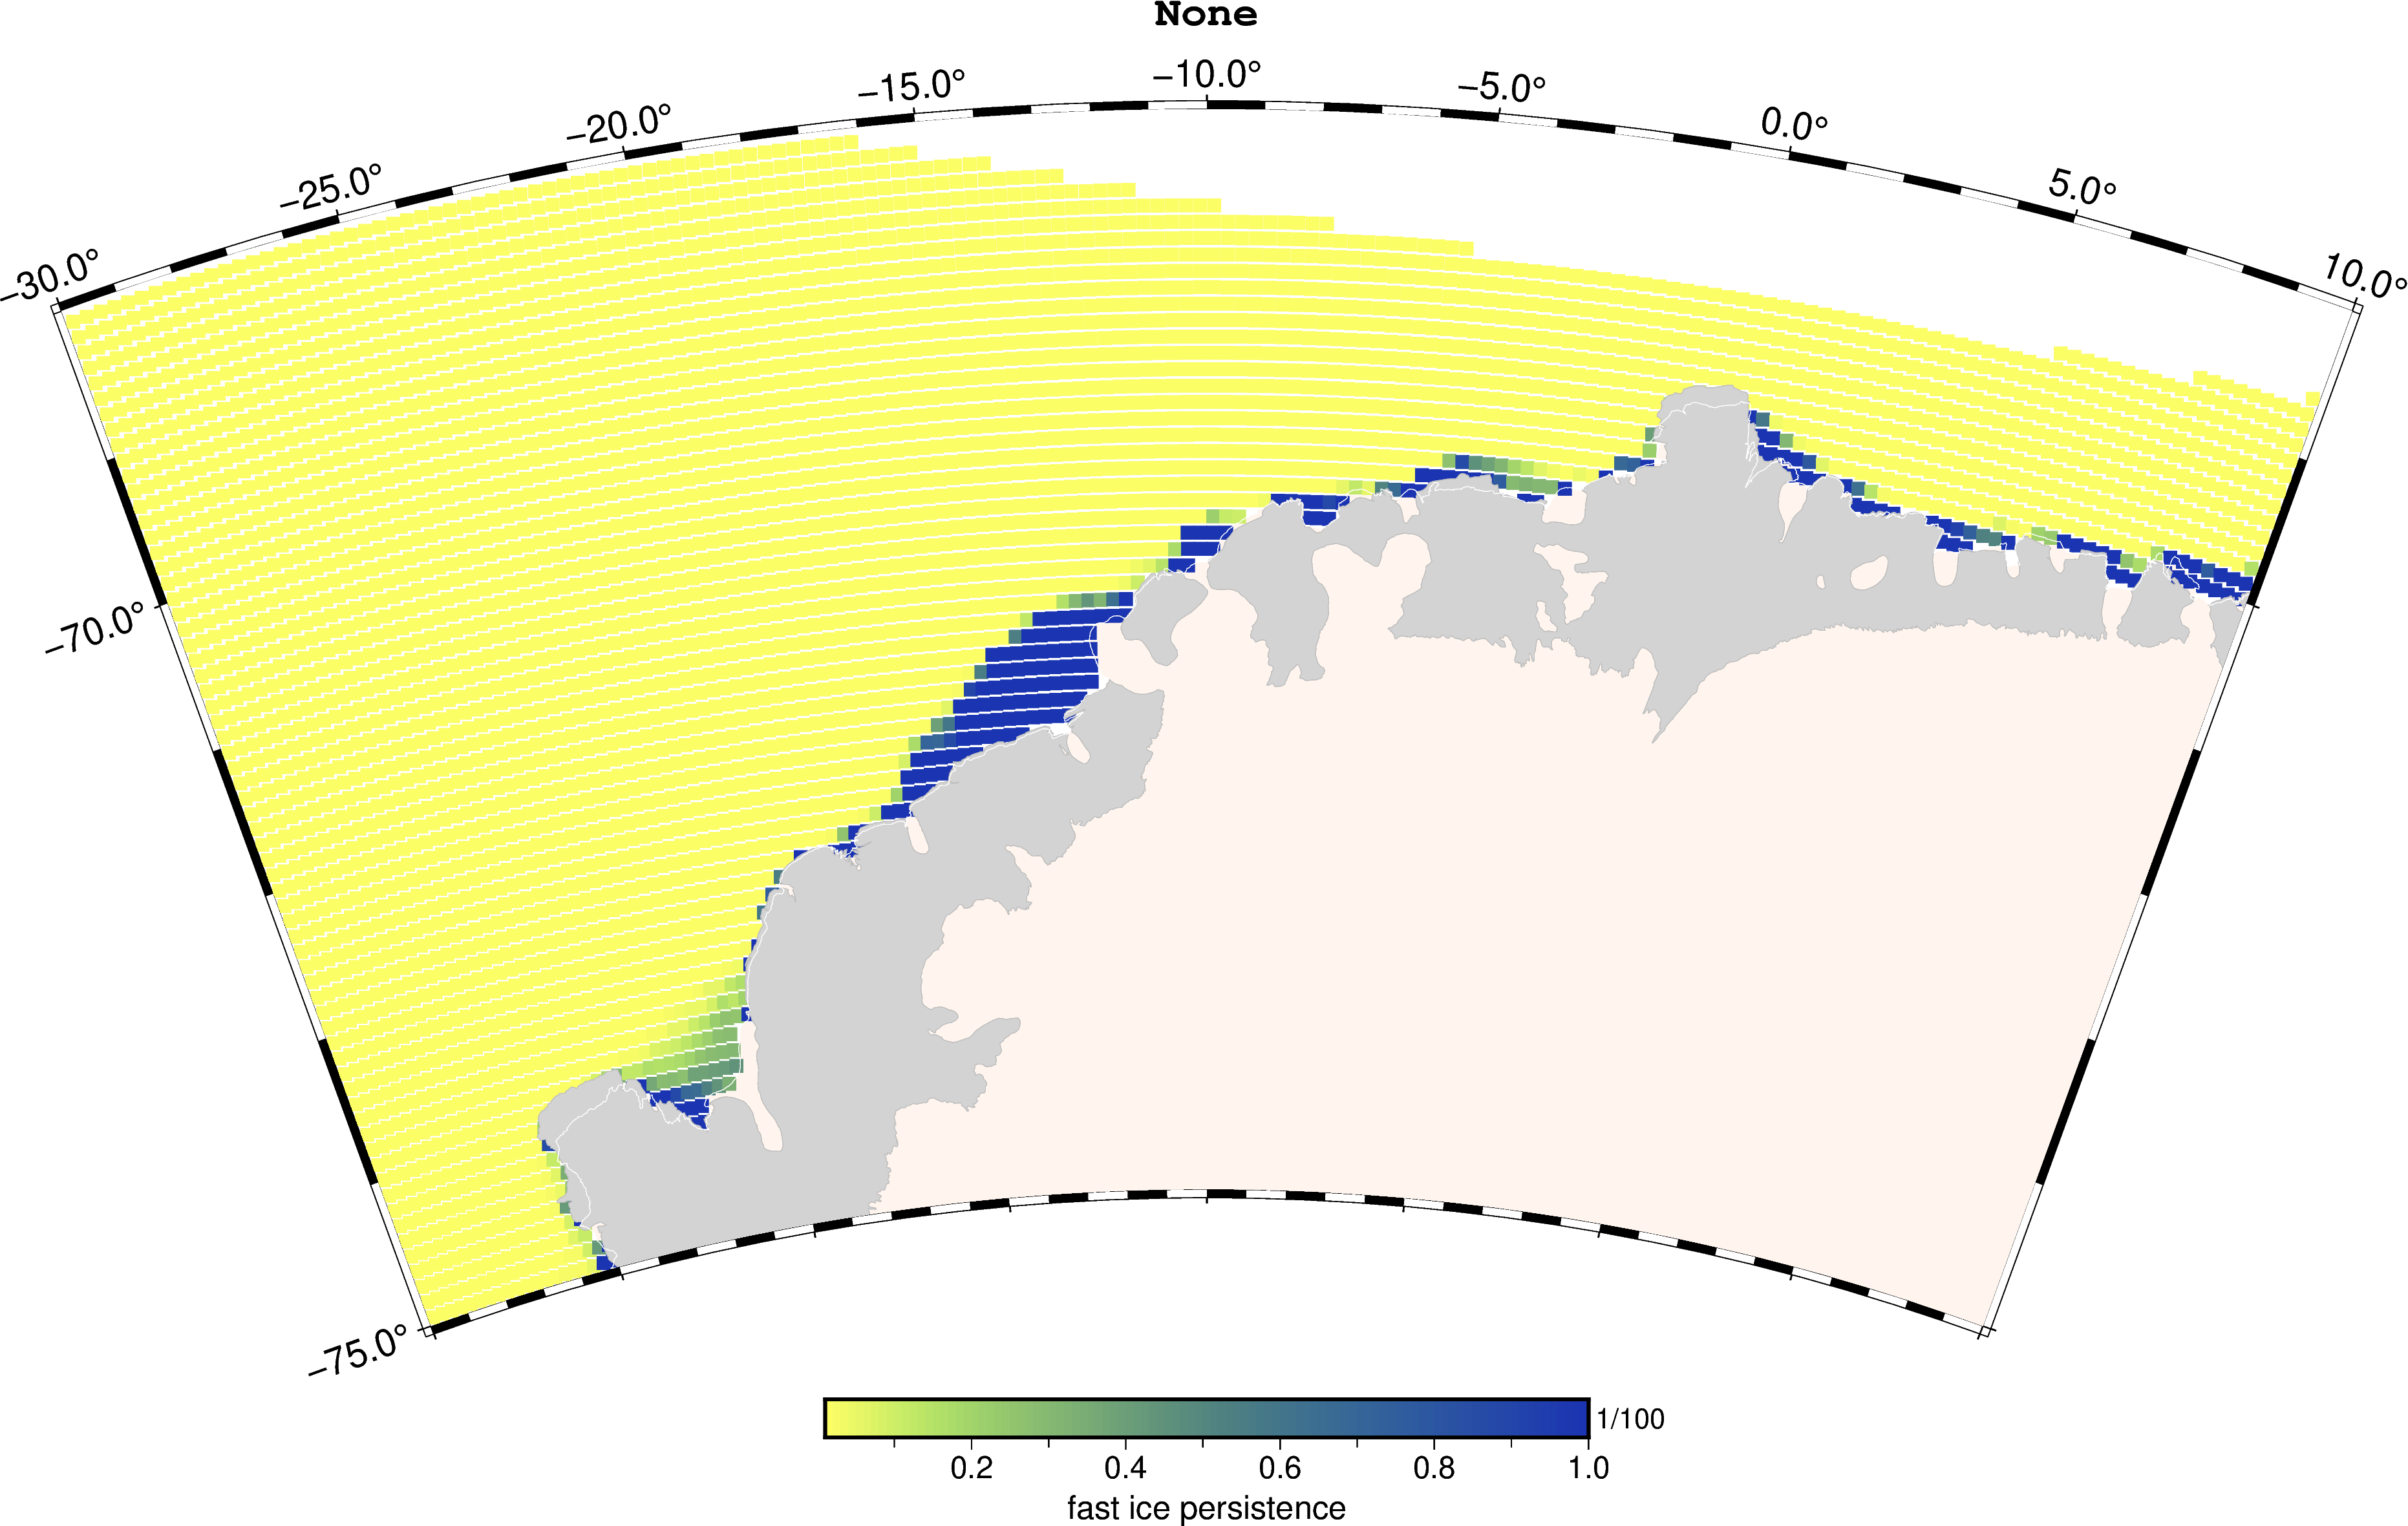

INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/AF20/WIO/FIP/FIP_2000-2018.png


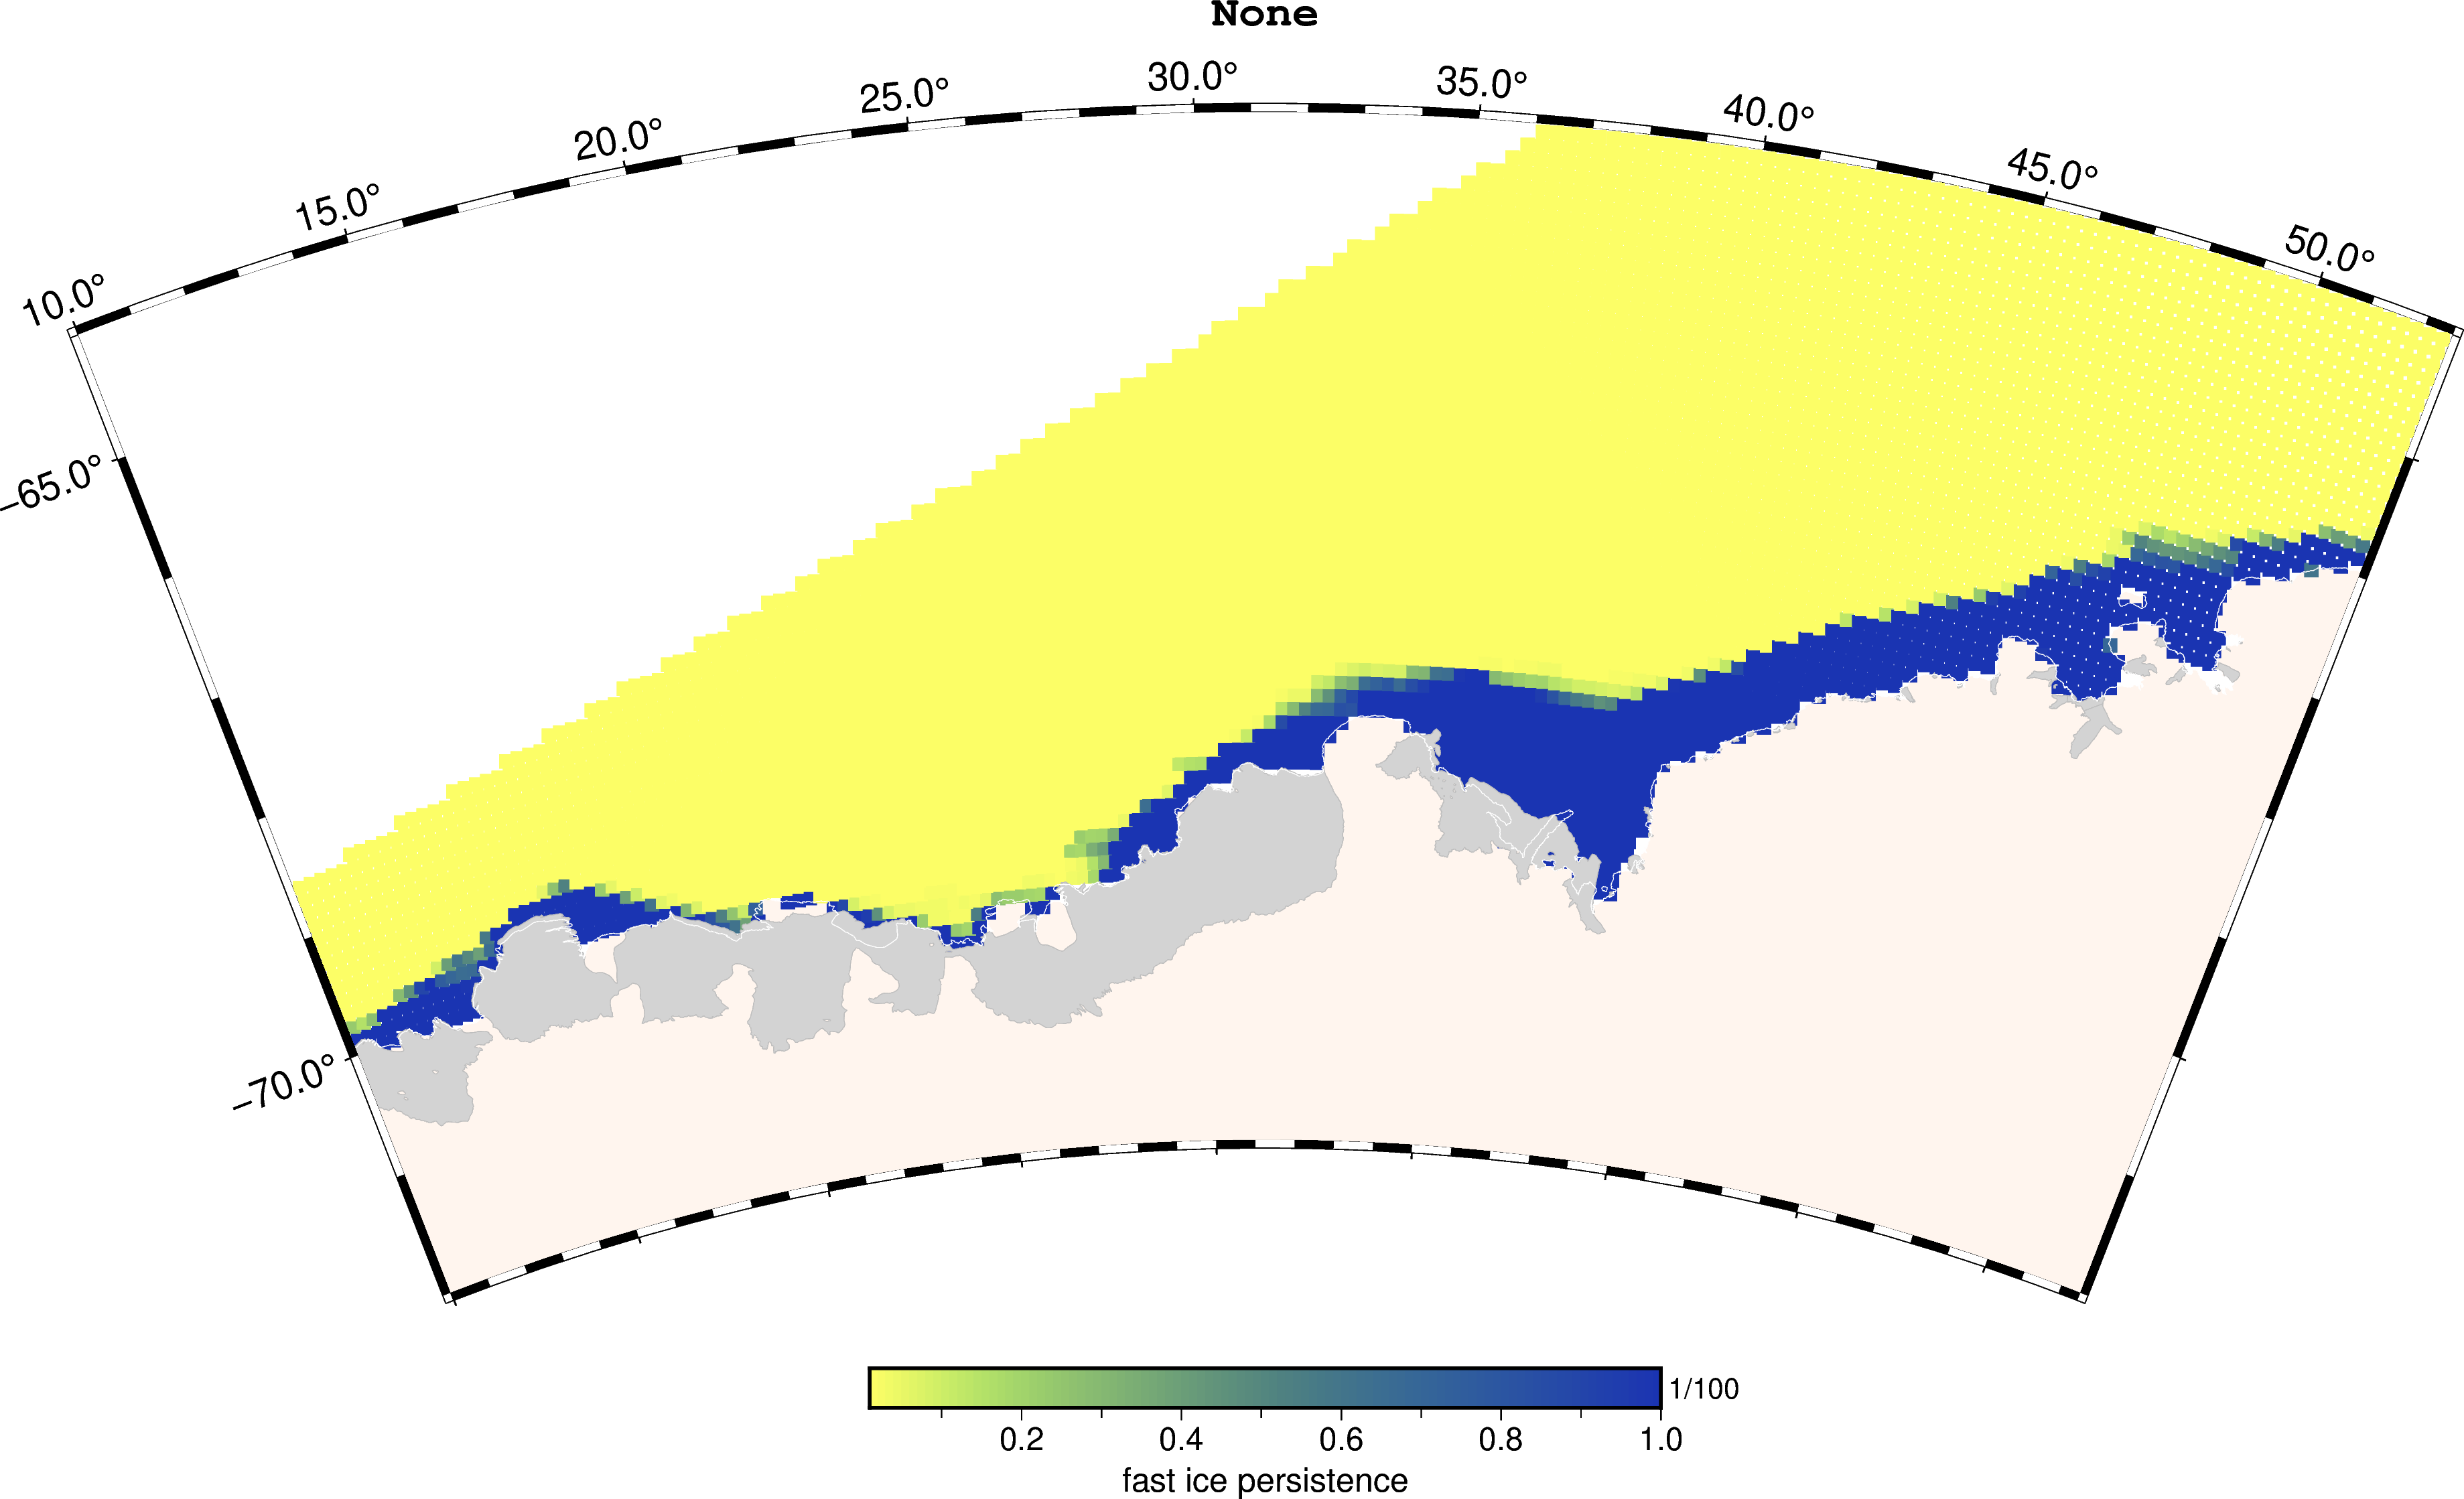

INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/AF20/EIO/FIP/FIP_2000-2018.png


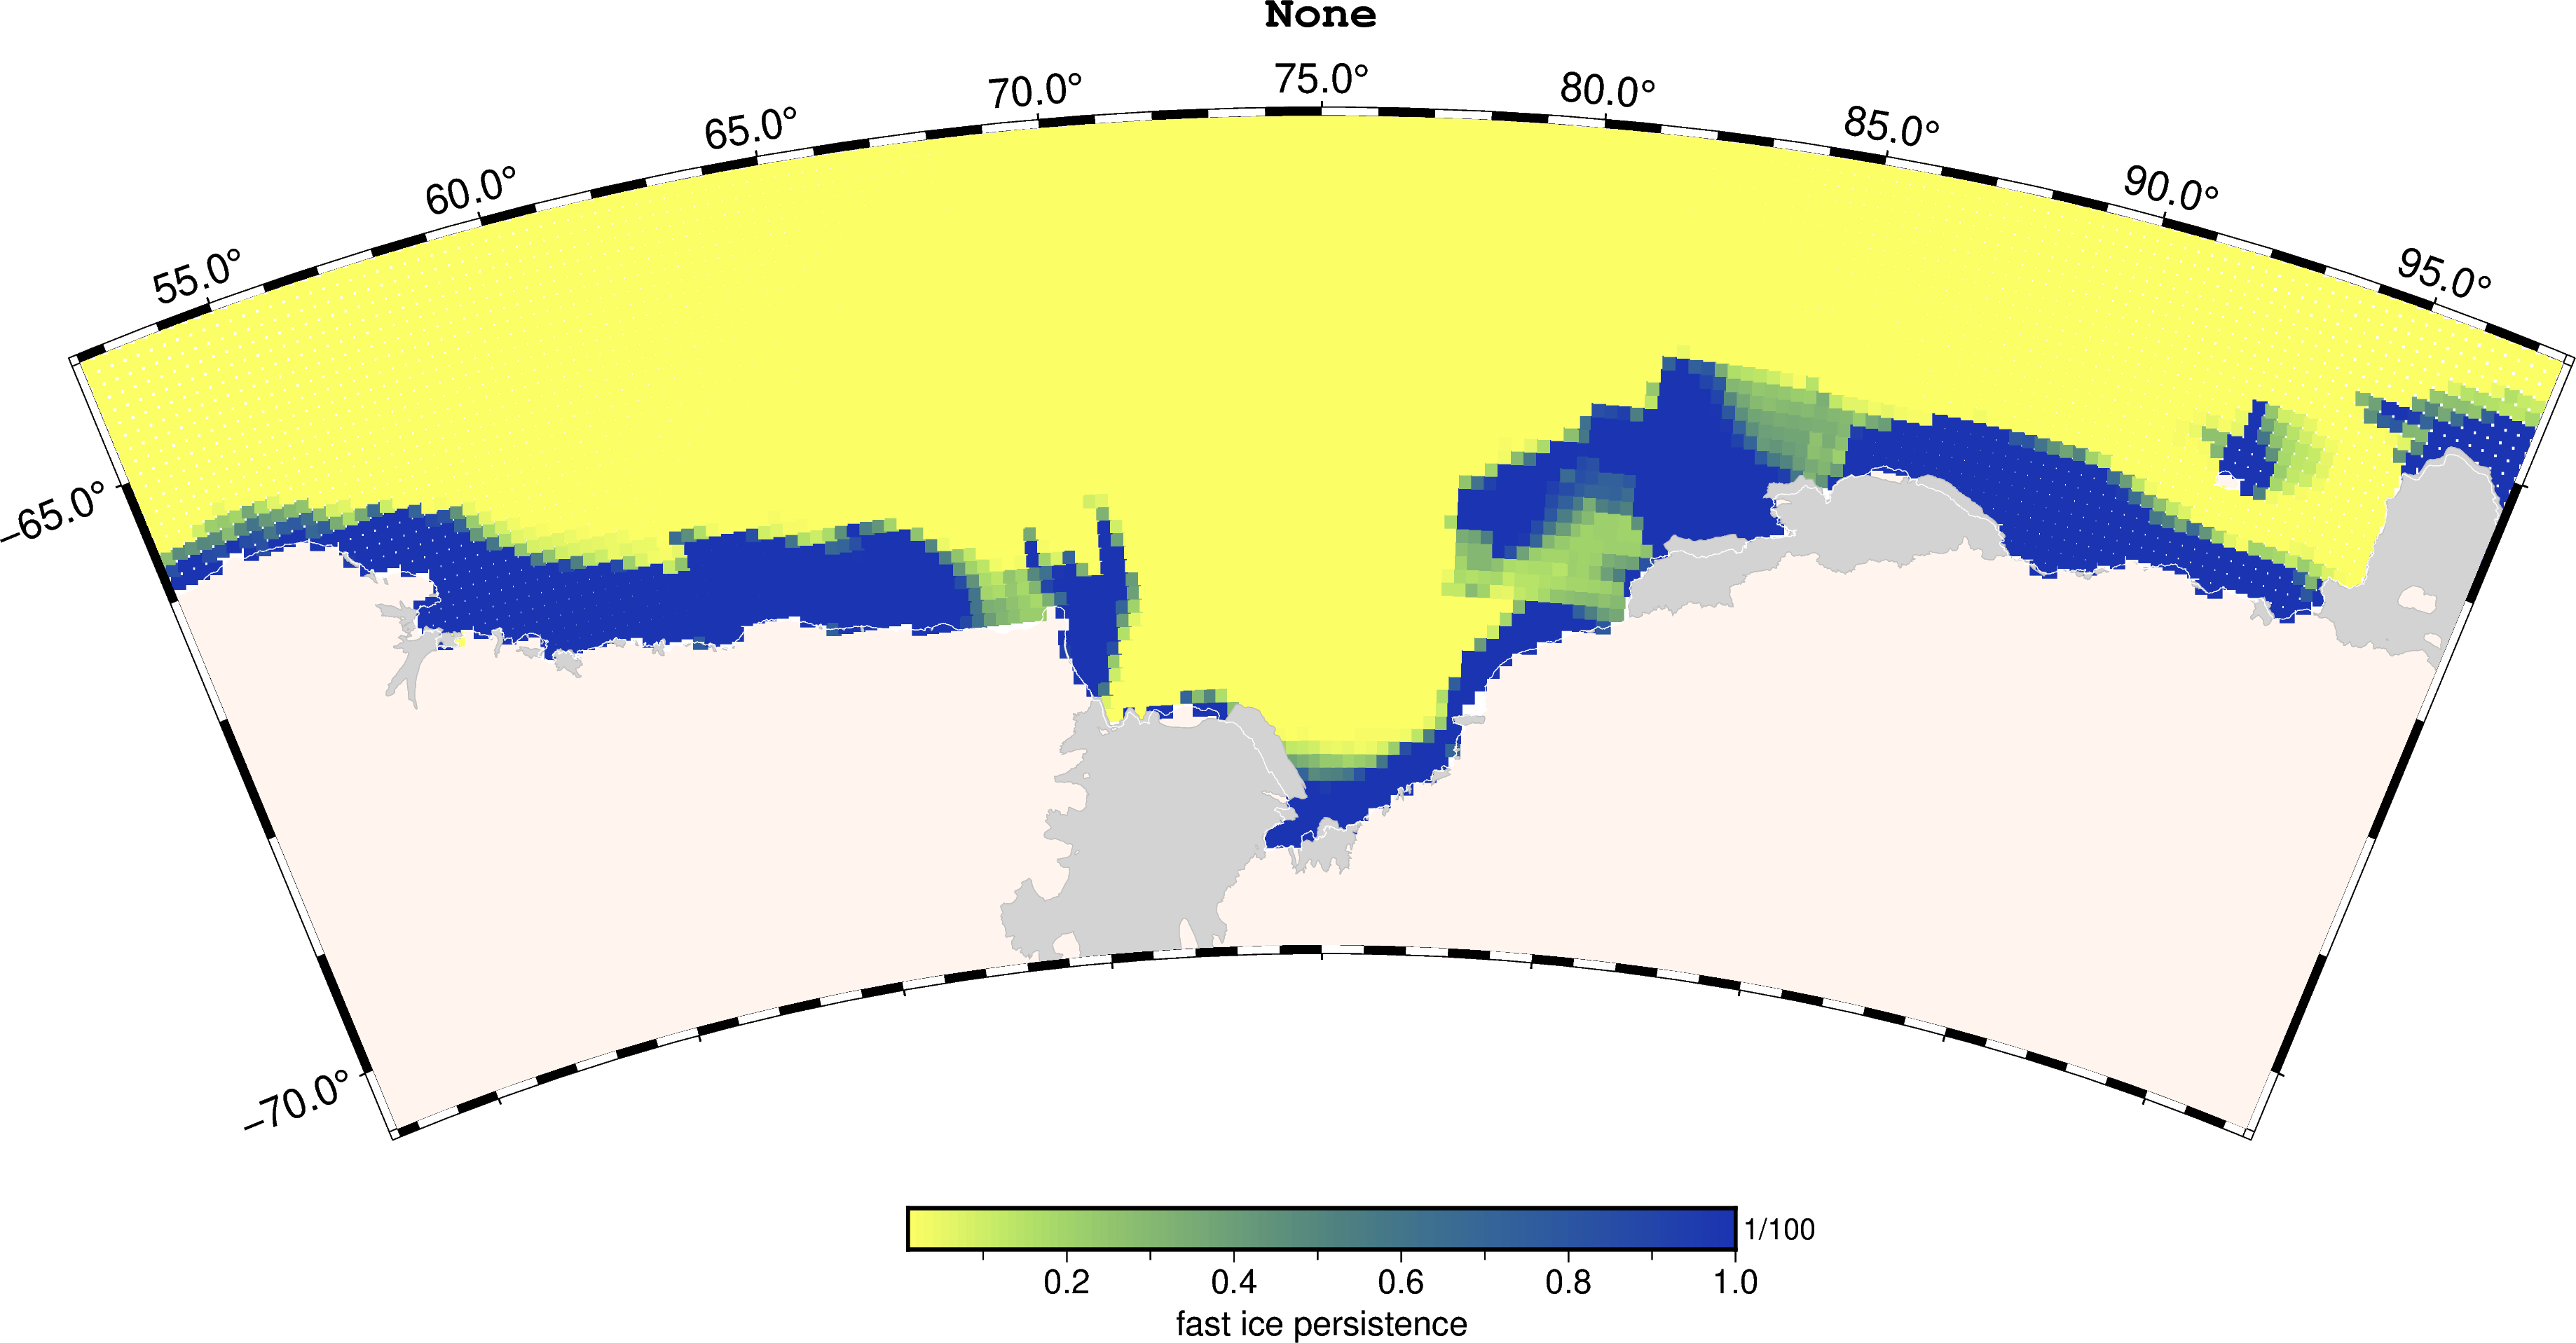

INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/AF20/Aus/FIP/FIP_2000-2018.png


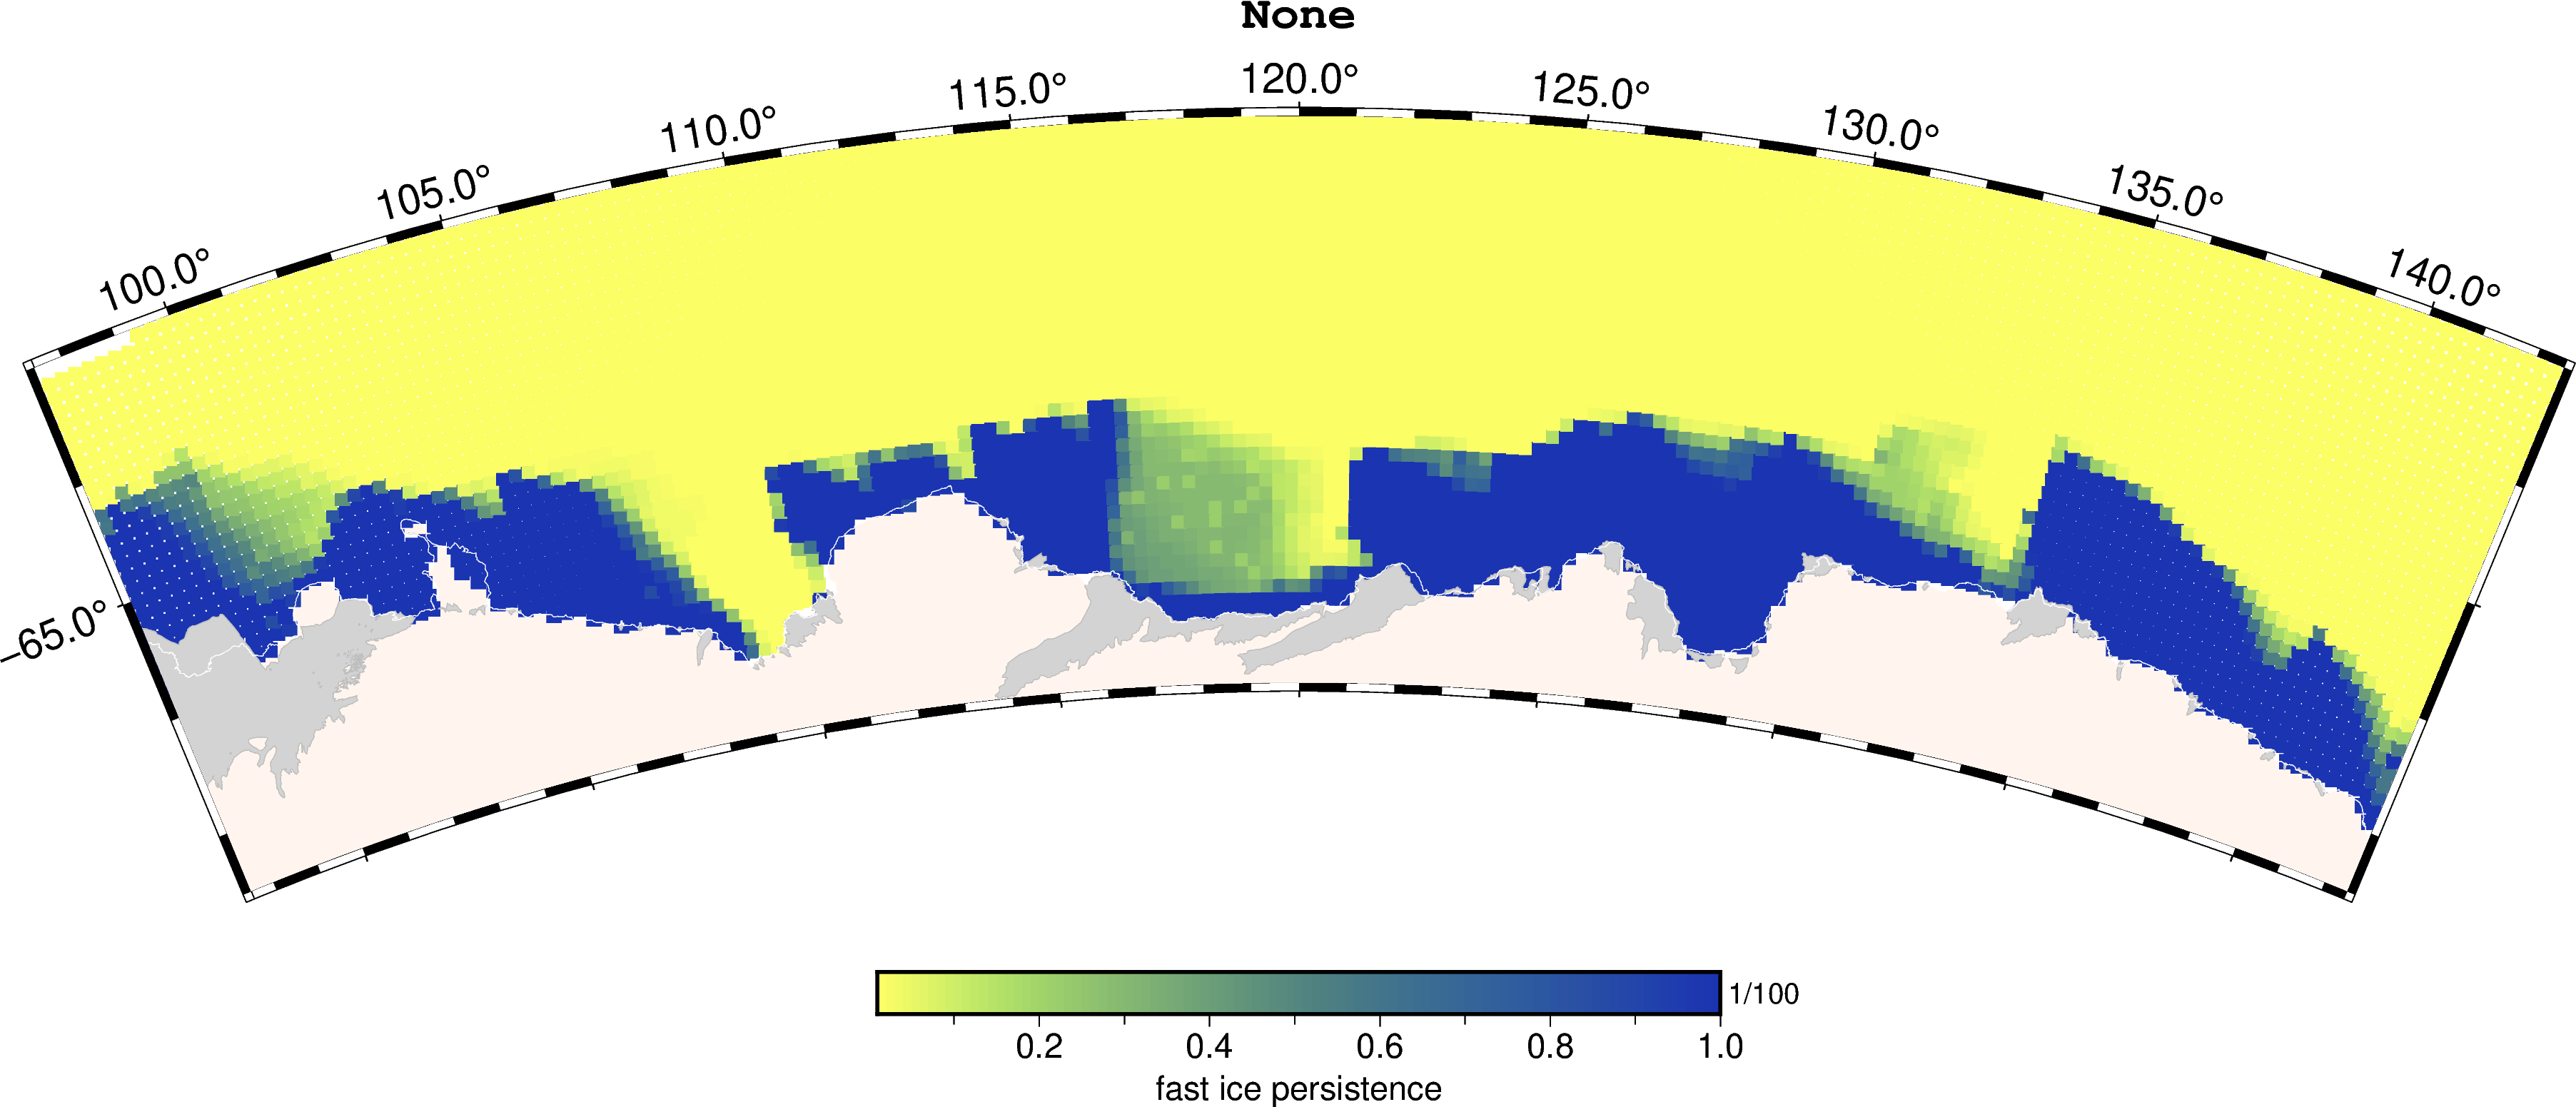

INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/AF20/VOL/FIP/FIP_2000-2018.png


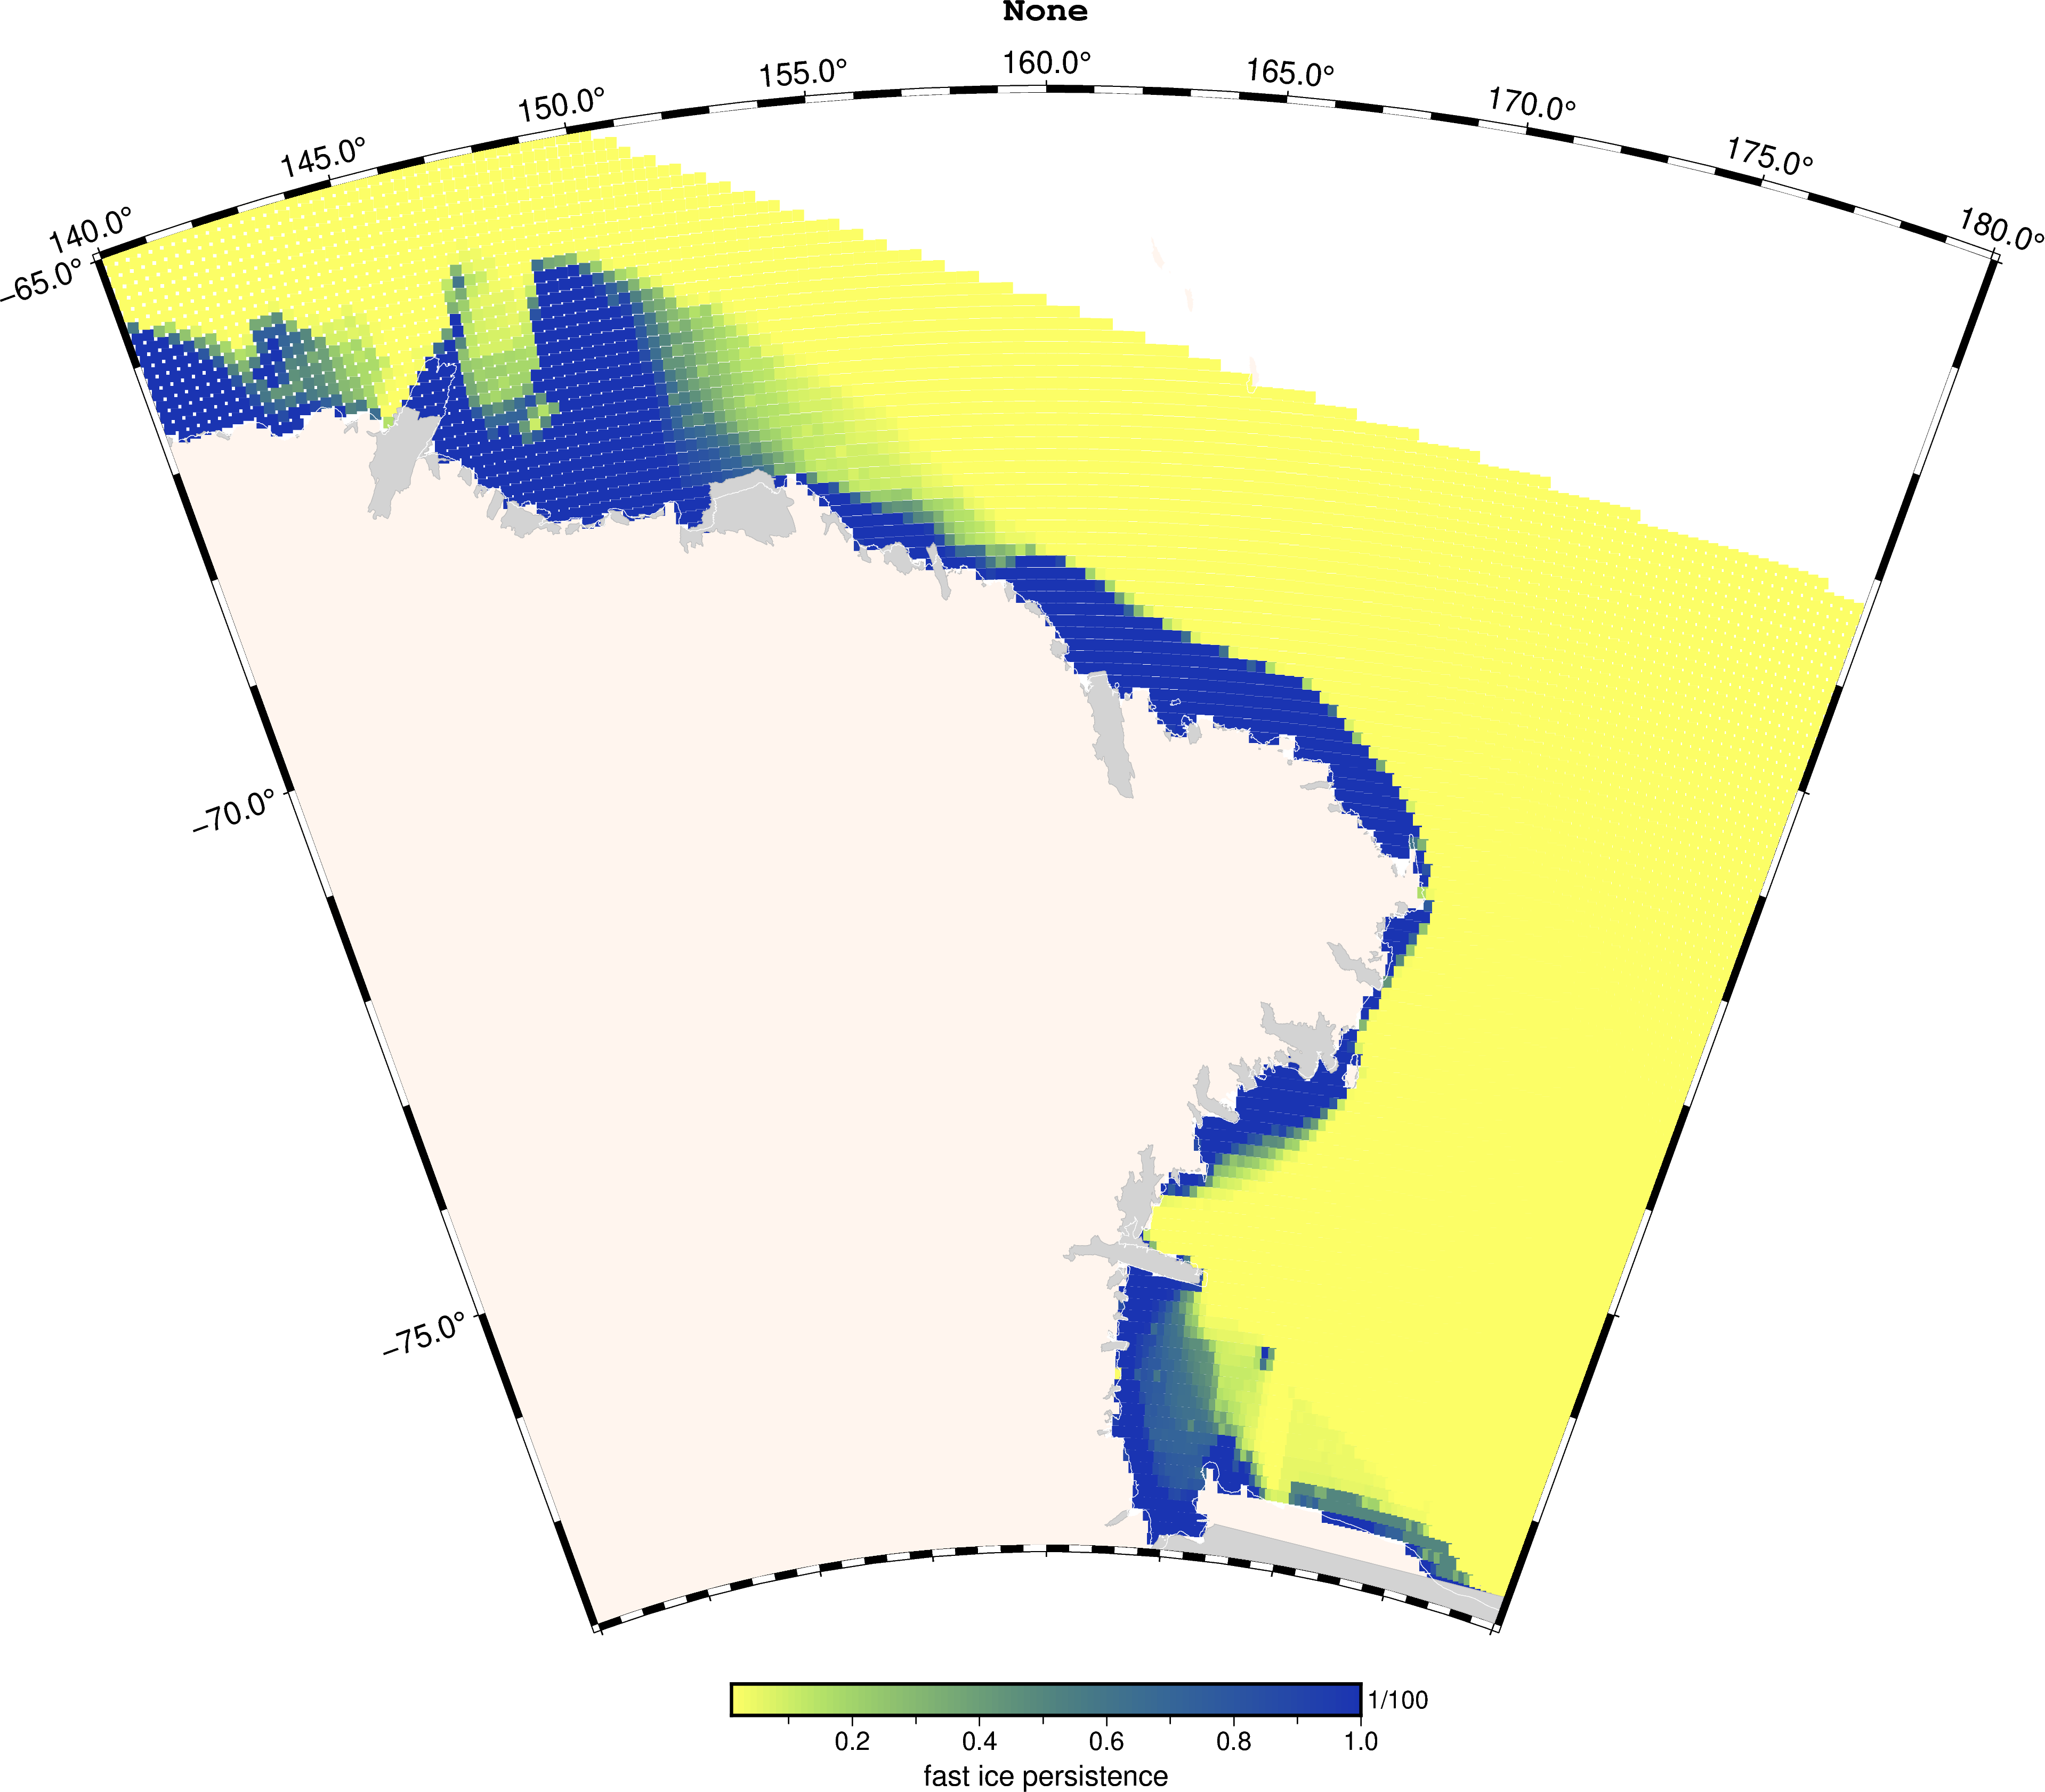

INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/AF20/AS/FIP/FIP_2000-2018.png


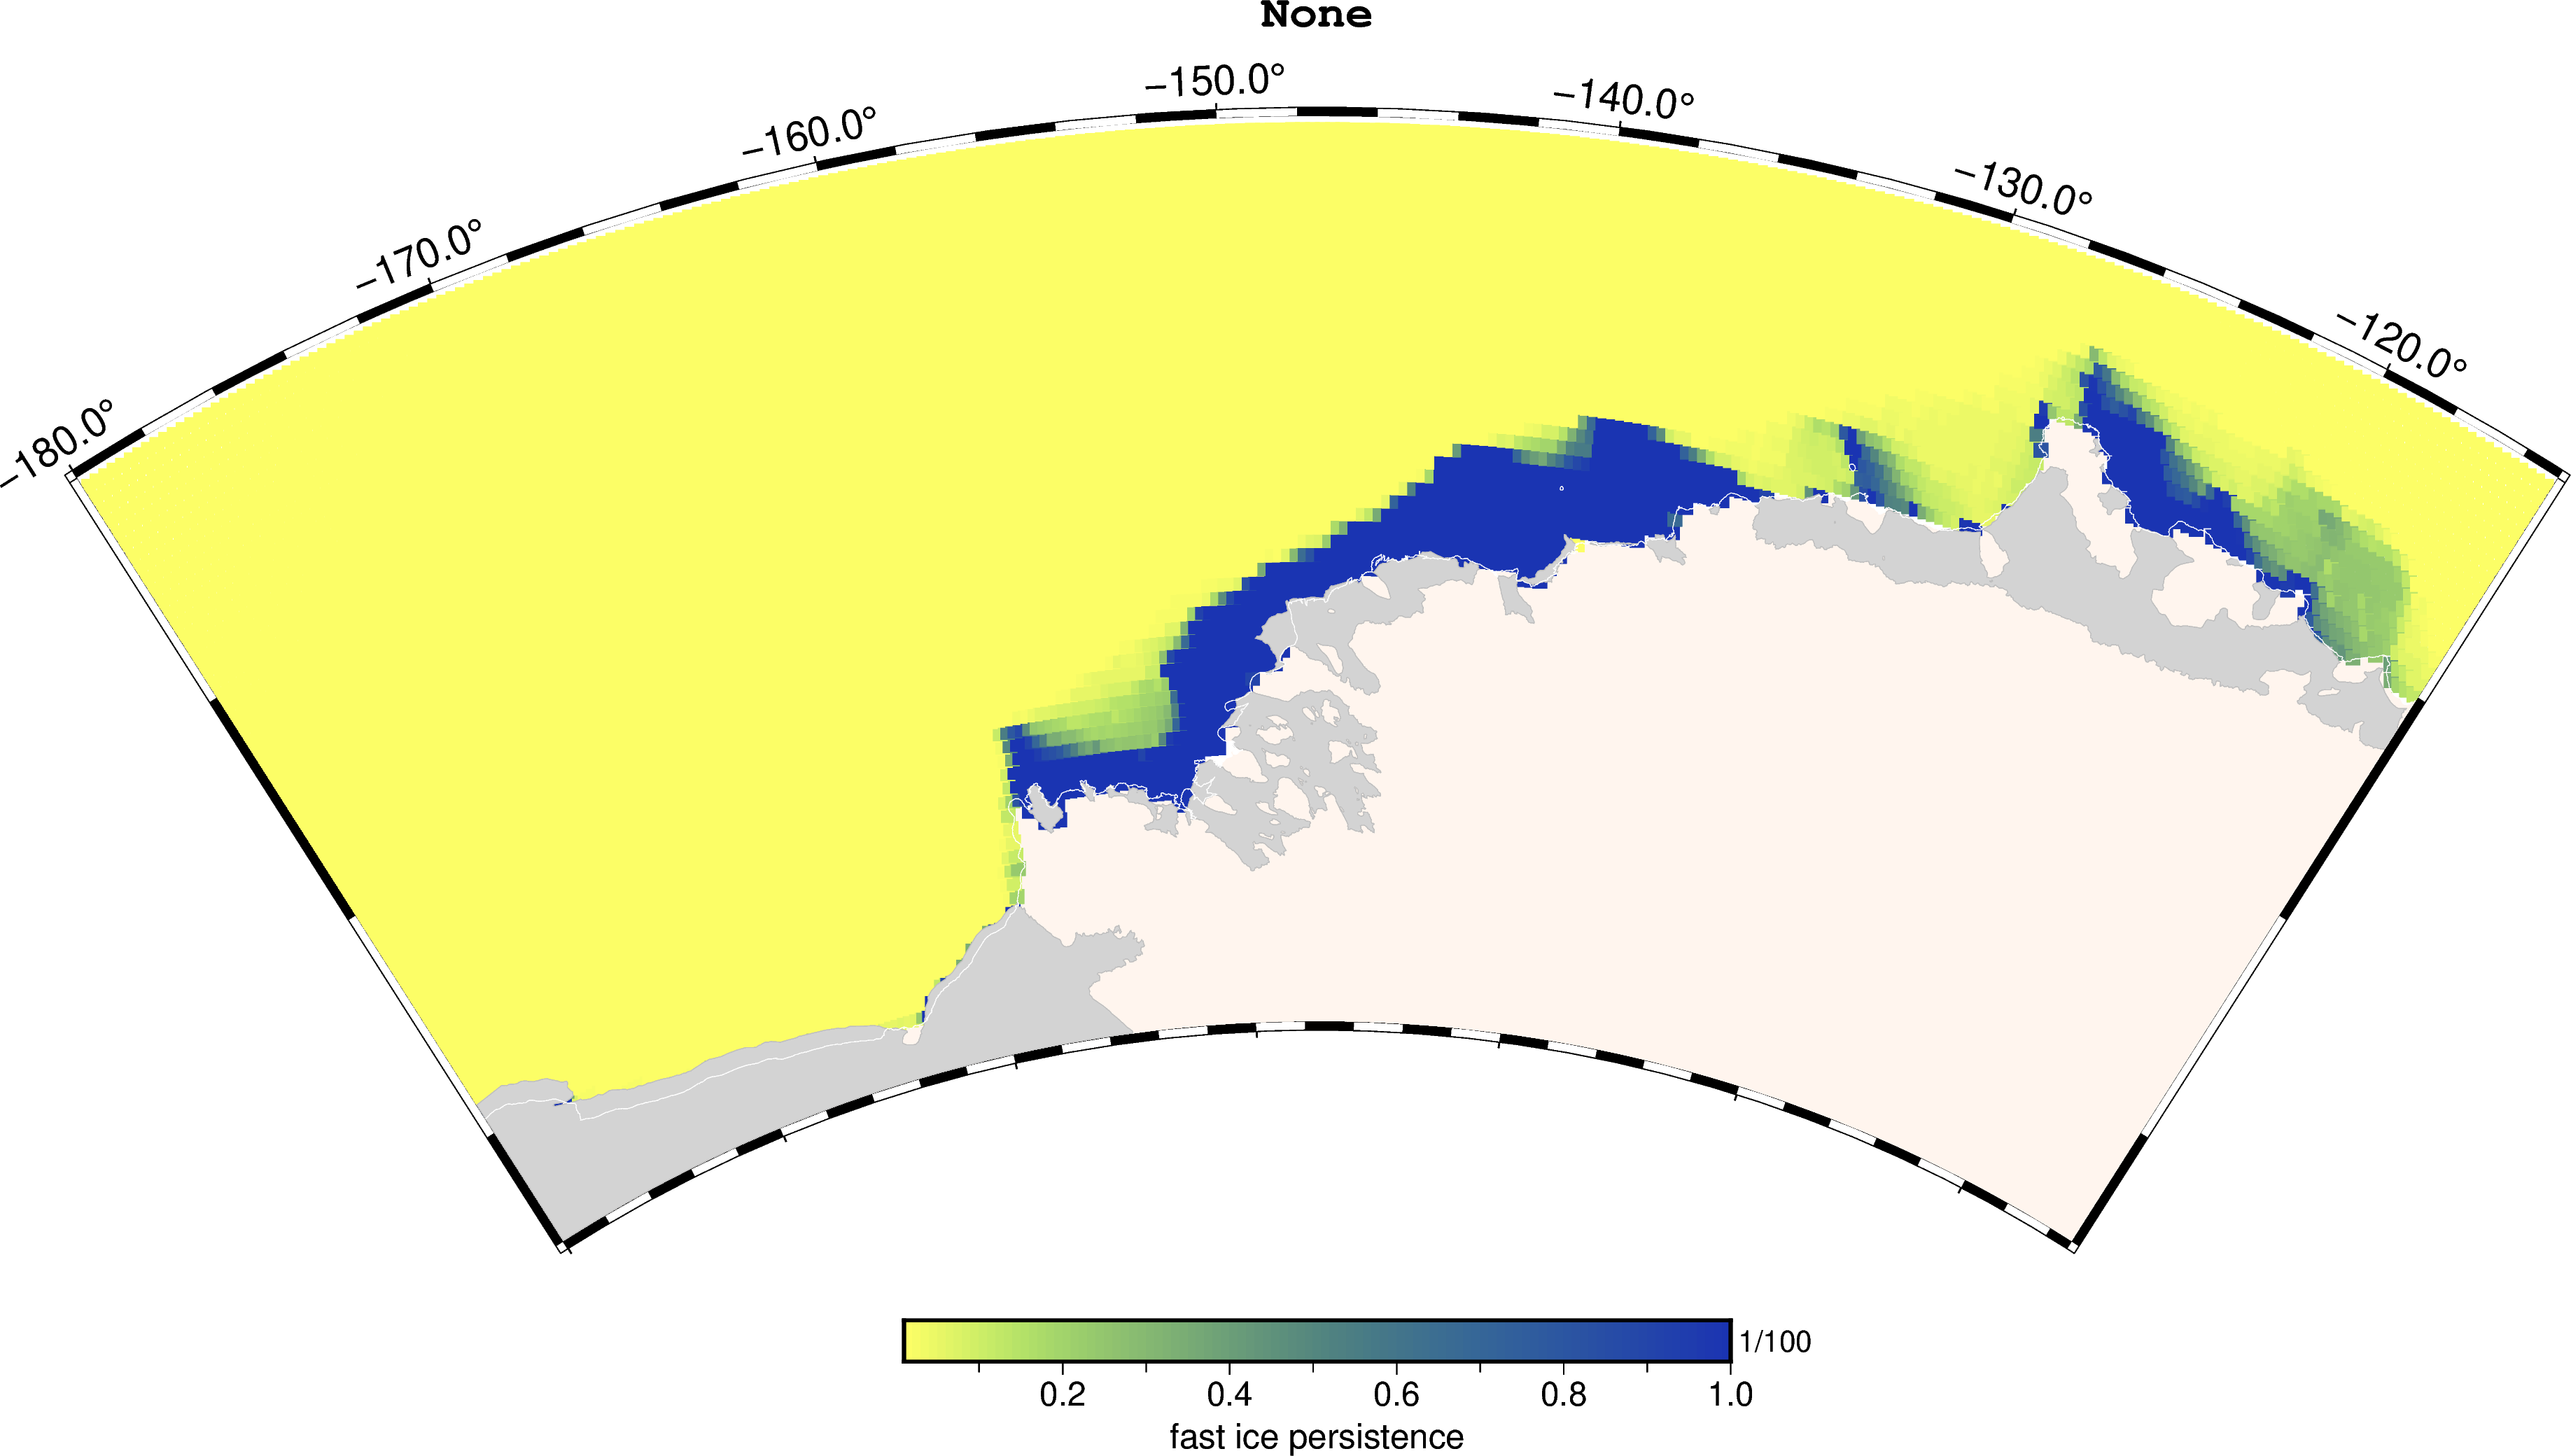

INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/AF20/BS/FIP/FIP_2000-2018.png


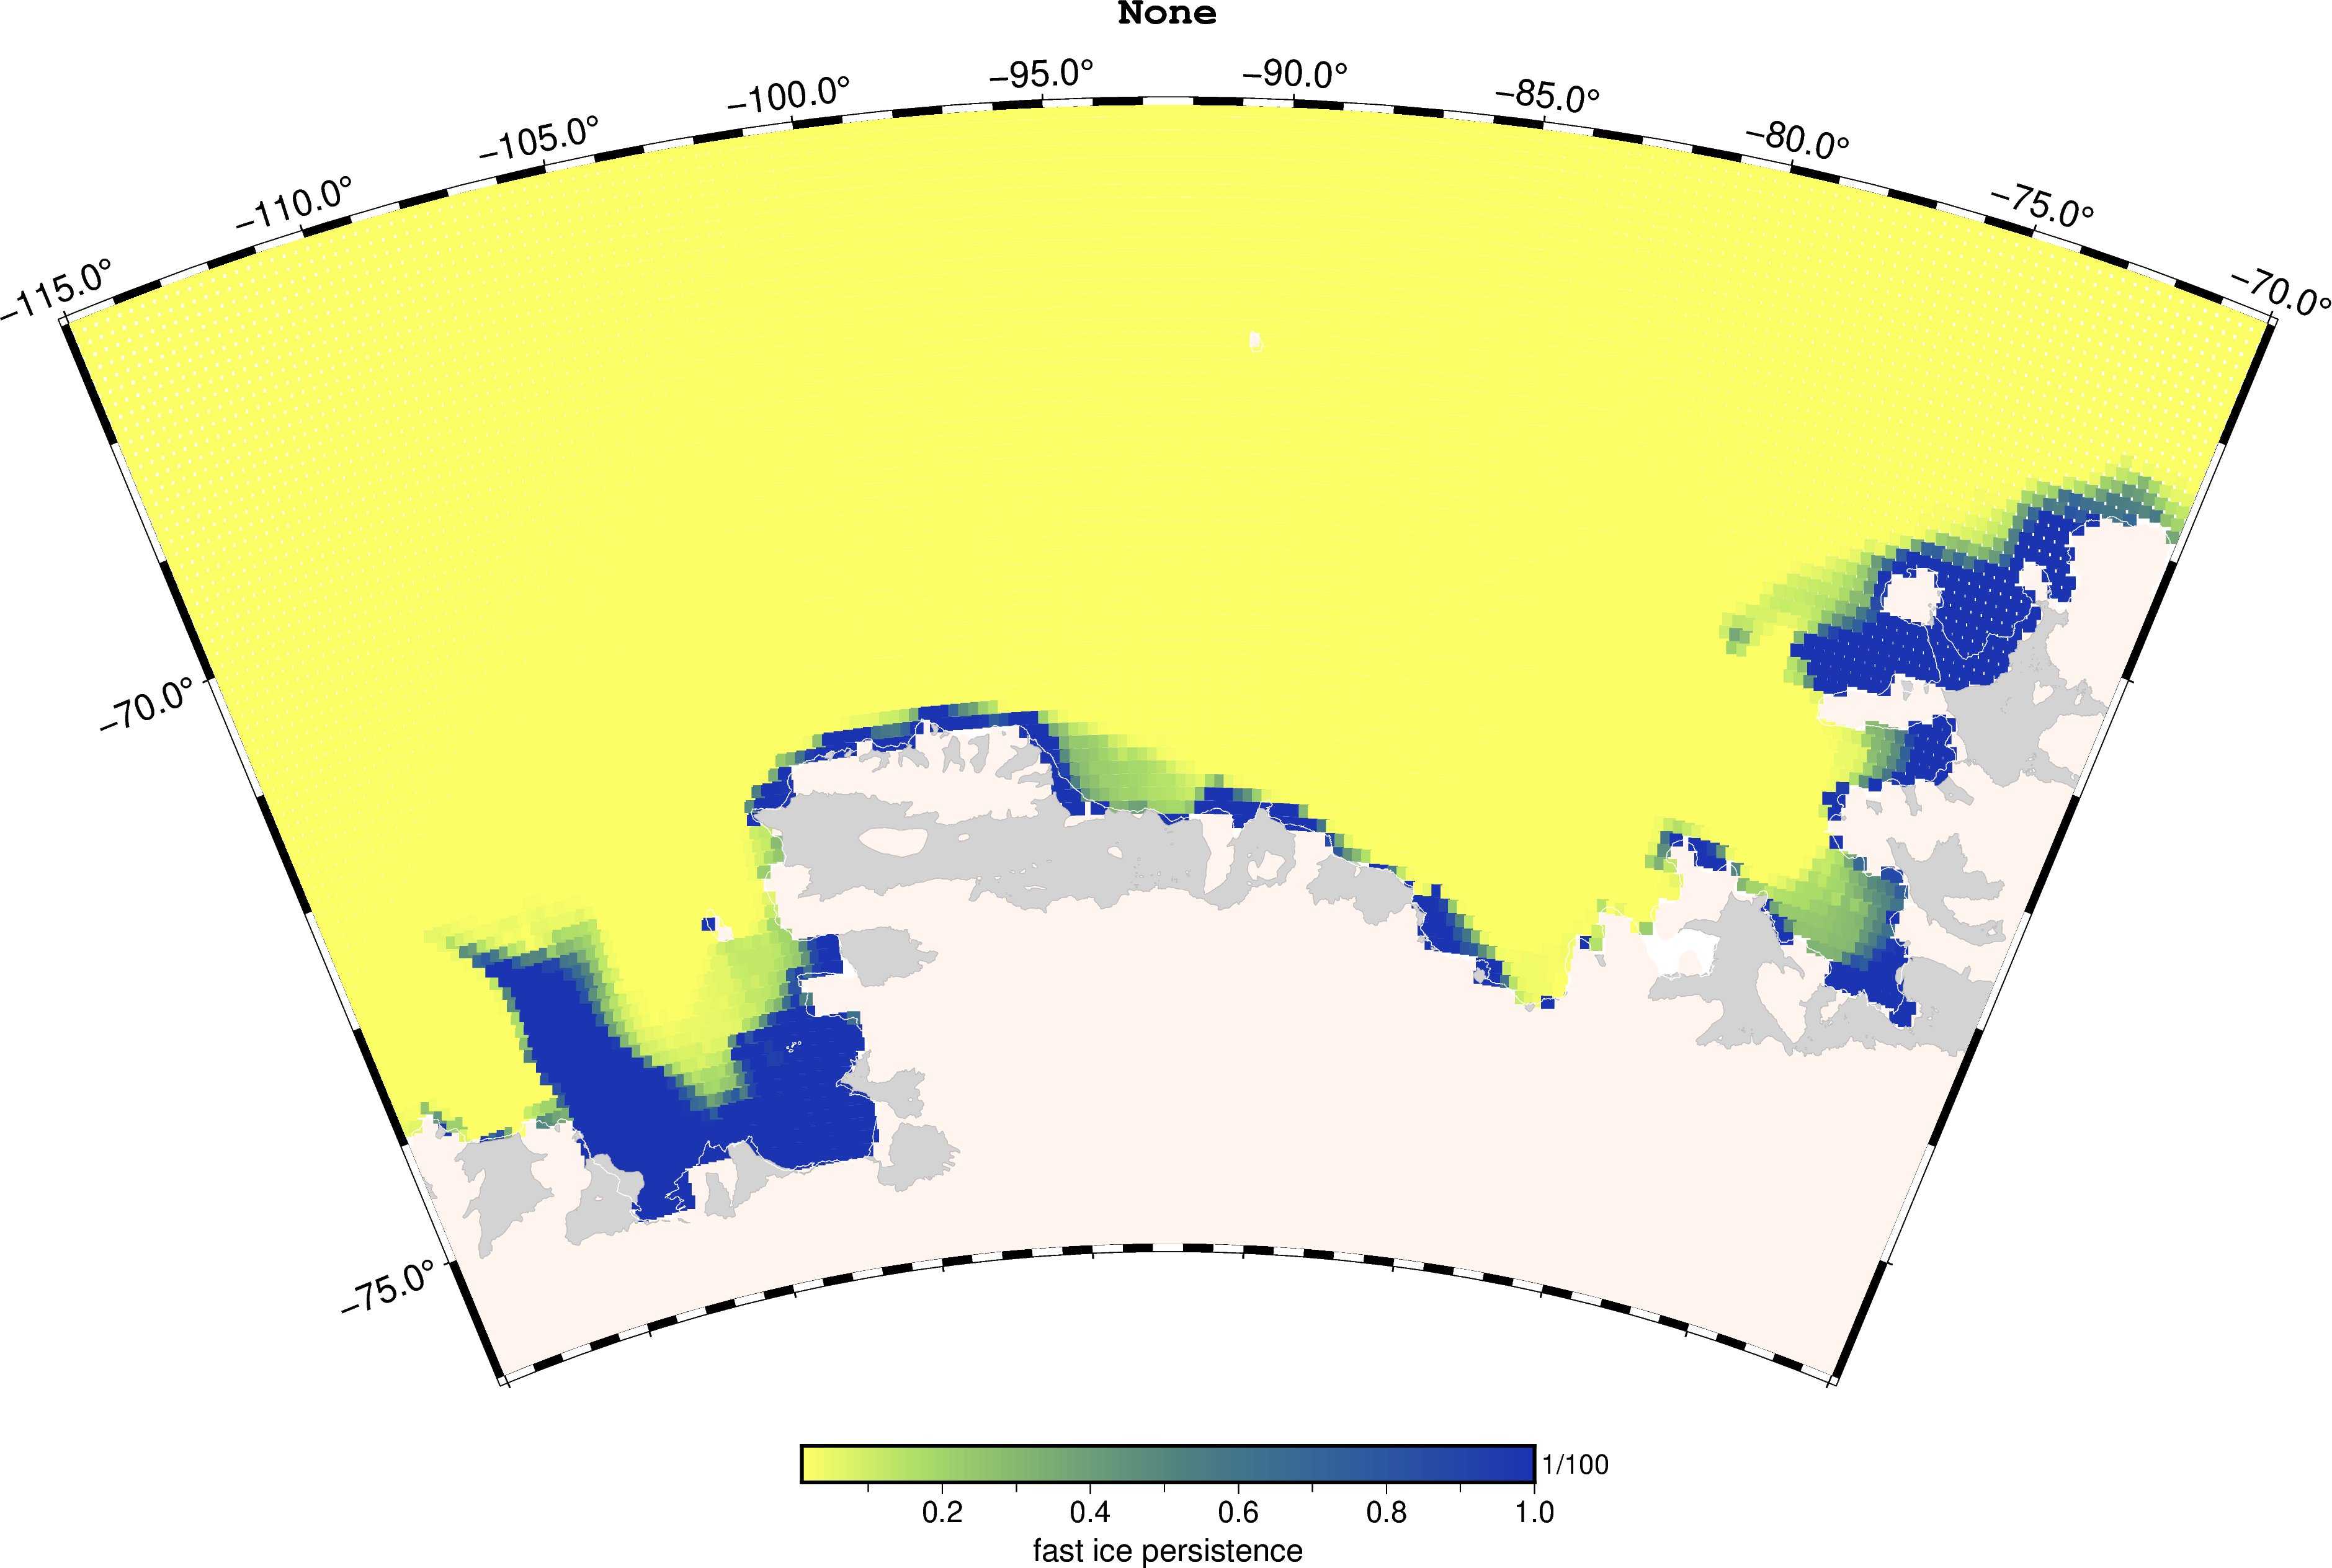

INFO:pyogrio._io:Created 357 records


📸 Saving figure: /g/data/gv90/da1339/GRAPHICAL/AFIM/AF20/WS/FIP/FIP_2000-2018.png


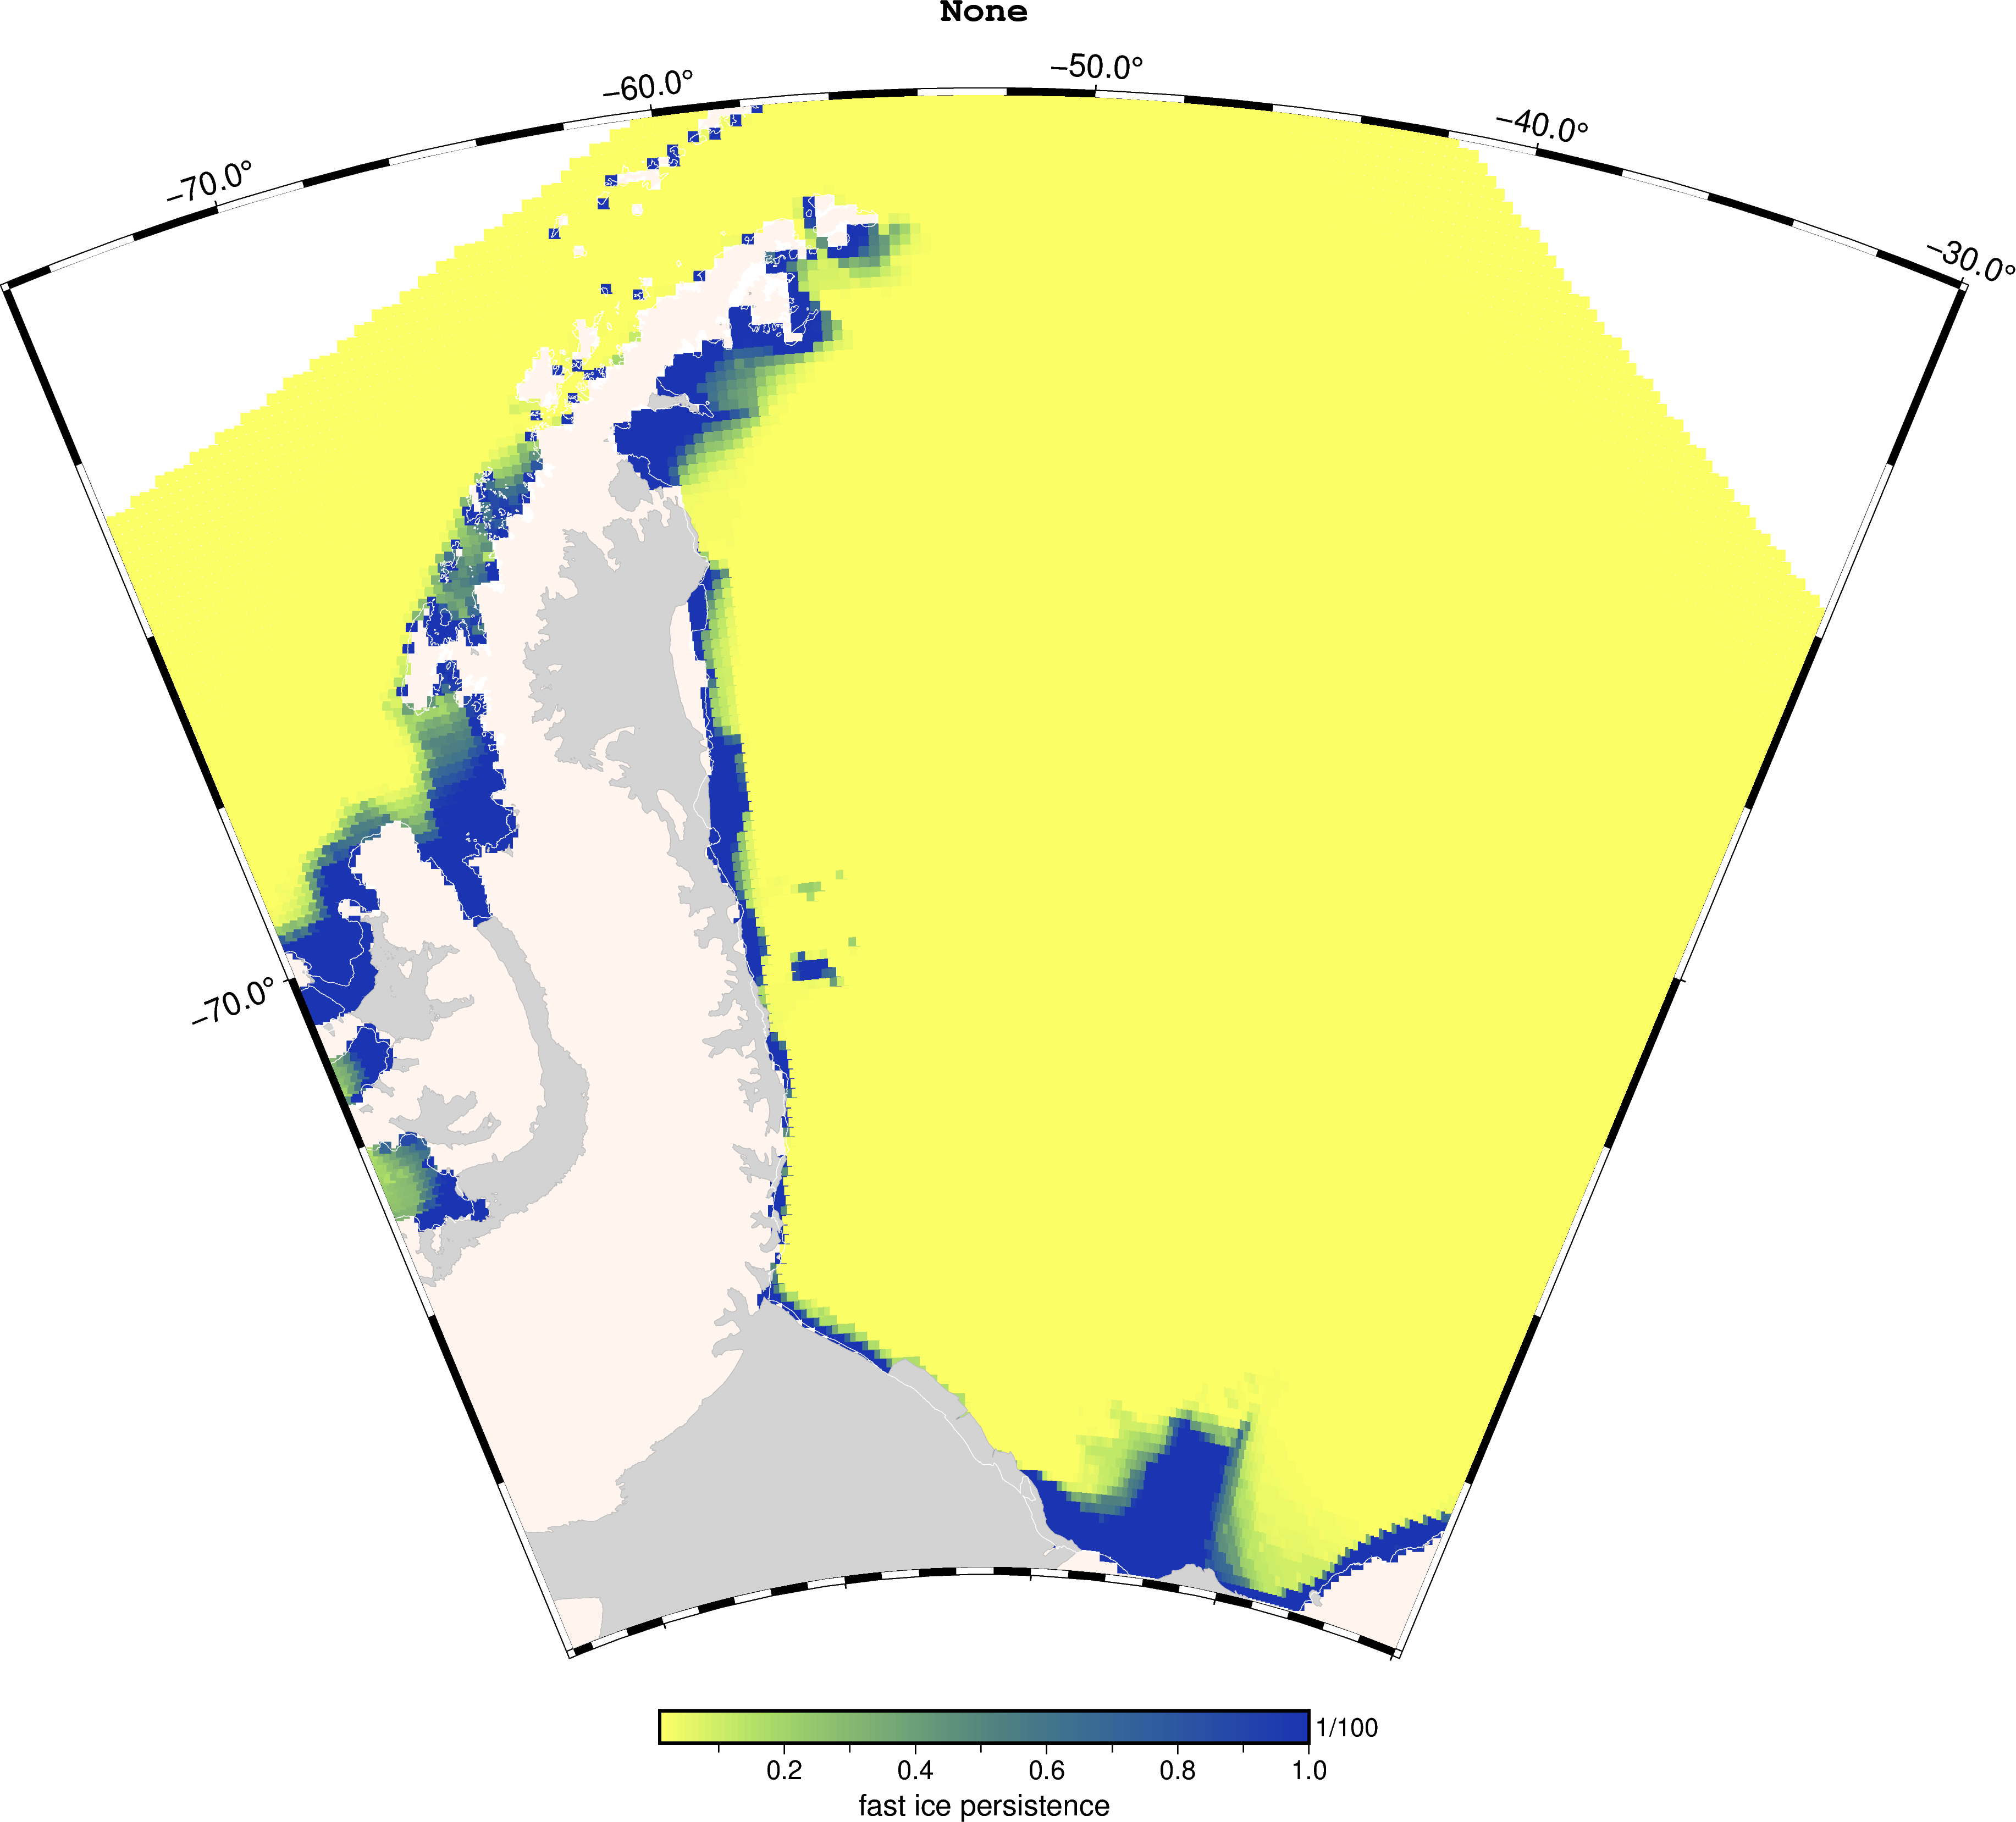

In [ ]:
SI_plot = SeaIcePlotter()
SI_plot.plot_persistence_map(FIP_obs_masked,
                             lon_coord_name = "obs_lon",
                             lat_coord_name = "obs_lat",
                             sim_name       = "AF20",
                             dt_range_str   = "2000-2018",
                             regional       = True,
                             plot_GI        = False,
                             overwrite_png  = True,
                             show_fig       = True)

In [ ]:
sim_name      = "elps-mid"
intersections = {}
line_colors   = {}
annotated     = {"min": False, "max": False}
figsize       = (15,10)
root          = Path(f"/home/581/da1339/AFIM_archive/{sim_name}/zarr")
fia_paths     = sorted(root.glob("ispd_thresh_*/metrics/FI_BT_*_mets.zarr"))
fia_data      = {"FI_BT_bool": defaultdict(list),
                 "FI_BT_roll": defaultdict(list),}
for zarr_path in fia_paths:
    match_thresh = re.search(r"ispd_thresh_([0-9.e+-]+)", str(zarr_path))
    match_method = re.search(r"FI_BT_(bool|roll)_mets", str(zarr_path))
    thresh = float(match_thresh.group(1))
    method = f"FI_BT_{match_method.group(1)}"
    print(zarr_path)
    ds = xr.open_zarr(zarr_path)
    fia = ds["FIA"]
    fia_filtered = fia.isel(time=slice(365, -1))
    fia_vals = fia_filtered.values
    # p1       = float(np.percentile(fia_vals, 1.0))
    # p99      = float(np.percentile(fia_vals, 99.0))
    # fia_data[method][thresh].append((p1, p99))
    p1       = float(np.percentile(fia_vals, 1.0))
    fia_max  = float(fia.max().values)
    fia_data[method][thresh].append((p1, fia_max))
for method, data in fia_data.items():
    thresholds = sorted(data.keys())
    p1_vals    = [np.mean([v[0] for v in data[t]]) for t in thresholds]
    max_vals   = [np.mean([v[1] for v in data[t]]) for t in thresholds]
    log_thresh = np.log10(thresholds)
    try:
        f_min = interp1d(p1_vals, log_thresh, bounds_error=False, fill_value="extrapolate")
        f_max = interp1d(max_vals, log_thresh, bounds_error=False, fill_value="extrapolate")
        if obs_min > 0:
            ispd_min = 10**f_min(obs_min)
            intersections[f"{method}_min"] = ispd_min
        if obs_max > 0:
            ispd_max = 10**f_max(obs_max)
            intersections[f"{method}_max"] = ispd_max
    except Exception as e:
        print(f"Failed interpolation for {method}: {e}")
fig, ax   = plt.subplots(figsize=figsize)
for method, data in fia_data.items():
    thresholds = sorted(data.keys())
    p1_vals    = [np.mean([v[0] for v in data[t]]) for t in thresholds]
    pmax_vals  = [np.mean([v[1] for v in data[t]]) for t in thresholds]
    print(f"\n{method}:")
    print("thresholds:", thresholds)
    print("p1_vals:", p1_vals)
    print("pmax_vals:", pmax_vals)
    linestyle  = "--" if "bool" in method else "-"
    marker_min = "v" if "bool" in method else "<"
    marker_max = "^" if "bool" in method else ">"
    ax.plot(thresholds, p1_vals, label=f"{method} - FIA min", linestyle=linestyle, marker=marker_min)
    ax.plot(thresholds, pmax_vals, label=f"{method} - FIA max", linestyle=linestyle, marker=marker_max)
# Gather colored lines for each method-label
line_styles = {}
for line in ax.get_lines():
    label = line.get_label()
    if "FIA min" in label or "FIA max" in label:
        method = label.split(" - ")[0]
        percentile = "min" if "min" in label else "max"
        line_styles[f"{method}_{percentile}"] = {"color": line.get_color(), 
                                                 "linestyle": line.get_linestyle(),}
# Build styled text lines for the summary box
text_lines = []
for label, thresh_val in intersections.items():
    is_min = "min" in label
    method = label.replace("_min", "").replace("_max", "")
    style = line_styles.get(f"{method}_{'min' if is_min else 'max'}", {})
    color = style.get("color", "black")
    text = f"{label}  : {thresh_val:.1e} m/s"
    text_line = TextArea(text, textprops=dict(color=color, fontsize=12))
    text_lines.append(text_line)
# Stack vertically and anchor in top right
box = VPacker(children=text_lines, align="left", pad=0, sep=2)
anchored_box = AnchoredOffsetbox(loc='upper center', child=box,
                                 pad=0.5, frameon=True, bbox_to_anchor=(0.5, 1),
                                 bbox_transform=ax.transAxes, borderpad=0.8)
ax.add_artist(anchored_box)
for label, thresh_val in intersections.items():
    is_min = "min" in label
    method = label.replace("_min", "").replace("_max", "")
    y_val = obs_min if is_min else obs_max
    offset = (10, 10) if is_min else (-10, -20)
    va = "bottom" if is_min else "top"
    # Get matching style
    style = line_styles.get(f"{method}_{'min' if is_min else 'max'}", {})
    color = style.get("color", "gray")
    linestyle = style.get("linestyle", "--" if is_min else "-")
    # Draw vertical line
    ax.axvline(thresh_val, color=color, linestyle=linestyle, linewidth=1.2)
# Observed lines
if obs_min > 0:
    ax.axhline(obs_min, color="black", linestyle="--", linewidth=1.0, label="Obs min (AF2020)")
if obs_max > 0:
    ax.axhline(obs_max, color="black", linestyle="-", linewidth=1.0, label="Obs max (AF2020)")
# Axes styling
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(100, 1e4)
#ax.set_xlim(2e-5, 5e-2)
ax.set_xlabel("Ice Speed Threshold (m/s)")
ax.set_ylabel("Fast Ice Area (1000-km²)")
ax.set_title(f"FIA min/max vs Ice Speed Threshold (1993–1999, {sim_name})")
ax.grid(True, which="both", linestyle="--", alpha=0.4)
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/AFIM/{sim_name}/ispd-thresh_vs_FIA-min-max.png")
plt.show()

In [ ]:
def plot_monthly_variable_maps(sim_name, ice_type, var_names, var_name_back=None, ispd_thresh=1.0e-3):
    if isinstance(var_names, str):
        var_names = [var_names]
    D_zarr  = Path(
    D_out   = Path(f"/g/data/gv90/da1339/afim_output/{sim_name}/zarr/ispd_thresh_{ispd_thresh_str}/{ice_type}")
    P_zarrs = sorted(D_out.glob(f"{ice_type}_*.zarr"))
    months  = [f.stem.split("_")[1] for f in P_zarrs]
    for yr_mo_str in months:
        P_zarr = D_out / f"{ice_type}_{yr_mo_str}.zarr"
        if not P_zarr.exists():
            print(f"\u26a0\ufe0f Missing dataset: {P_zarr}")
            continue
        ds              = xr.open_dataset(P_zarr, engine="zarr")
        dt_start        = pd.Timestamp(f"{yr_mo_str}-01")
        dt_end          = dt_start + pd.offsets.MonthEnd(0)
        yr_mo_start_str = dt_start.strftime("%Y-%m-%d")
        yr_mo_end_str   = dt_end.strftime("%Y-%m-%d")
        if ice_type=="SO":
            ice_type_plot = "SI"
        else:
            ice_type_plot = ice_type
        plotter = SeaIcePlotter(sim_name   = sim_name,
                                ice_type   = ice_type_plot,
                                plot_type  = 'regional',
                                hemisphere = 'south',
                                save_fig   = True,
                                show_fig   = False,
                                overwrite  = False )
        for var in var_names:
            if var not in ds:
                print(f"Skipping {var}: not found in {P_zarr}")
                continue
            print(f"Plotting {var} for {yr_mo_str}")
            extra_kwargs = {"ispd_thresh"   : ispd_thresh,
                            "var_name_back" : var_name_back,
                            "series"        : [0.0, 0.5] if var == "ispd" else None}
            if var == "aice" and ice_type=="FI":
                extra_kwargs = {"cmap": "viridis", "series": [0.9, 1], "cmap_reverse": True}
            elif var == "divu":
                extra_kwargs = {"cmap": "mag", "series": [-10, 10], "cmap_reverse": False}
            plotter.plot_map(ds            = ds,
                             var_name      = var,
                             var_name_back = var_name_back,
                             dt0_str       = yr_mo_start_str,
                             dtN_str       = yr_mo_end_str,
                             time_coord_name = "time",
                             lon_coord_name  = "lon",
                             lat_coord_name  = "lat",
                             **{k: v for k, v in extra_kwargs.items() if v is not None} )

In [ ]:
root = Path.home() / "AFIM_archive/elps-min/zarr"
zarr_paths = sorted(root.glob("iceh_*.zarr"))
bad_paths = []

for zarr_path in zarr_paths:
    try:
        ds = xr.open_zarr(zarr_path, consolidated=True)
        # Check if 'aice' exists and has expected dims
        if 'aice' not in ds:
            print(f"❌ Missing 'aice' in {zarr_path}")
            bad_paths.append(zarr_path)
        else:
            print(f"✅ 'aice' OK in {zarr_path}")
    except Exception as e:
        print(f"❌ Failed to open {zarr_path}: {e}")
        bad_paths.append(zarr_path)

print("\n🧾 Summary:")
print(f"{len(bad_paths)} files failed out of {len(zarr_paths)}")

In [ ]:
bool_mask = SI_proc.boolean_fast_ice(DS_FI['FI_mask'], dim="time", window=7, min_count=6)

In [ ]:
P_METS = Path(D_out,f"FI_BT_bool_mets.zarr")
DS_bool   = CICE_SO.where(bool_mask)
DS_bool["FI_mask"] = DS_FI["FI_mask"]
METS      = compute_and_save_metrics(SI_proc, DS_bool, P_METS, obs_clim=obs_clim)
save_metrics_csv(METS, sim_name=sim_name, i_type=i_type, ispd_str=ispd_str, D_out=D_out)

In [ ]:
sim_name       = "FI-heavy"
ispd_thresh    = 2.5e-4
ispd_type      = ['ispd_B','ispd_Ta','ispd_Tx', 'ispd_BT']
dt0_str        = "1999-08-01"
dtN_str        = "1999-10-31"
SI_proc        = SeaIceProcessor(sim_name = sim_name,
                                 dt0_str  = dt0_str,
                                 dtN_str  = dtN_str,
                                 ice_speed_threshold = ispd_thresh)
#FI           = SI_proc.process_daily_cice( overwrite_zarr_group=False )
#FI_roll      = SI_proc.process_rolling_cice( overwrite_zarr_group=False )
FI, CICE_raw         = SI_proc.load_processed_cice( zarr_CICE=True )
FI_roll, CICE_roll   = SI_proc.load_processed_cice( rolling=True, zarr_CICE=True )
CICE_raw             = SI_proc.compute_ice_speed_types( CICE_raw, ispd_type )
CICE_raw             = SI_proc.reapply_landmask(CICE_raw)
CICE_raw['ispd_BT']  = SI_proc.compute_composite_ice_speed(CICE_raw)
CICE_roll            = SI_proc.compute_ice_speed_types(CICE_roll, ispd_type, temporally_average=True)
CICE_roll            = SI_proc.reapply_landmask(CICE_roll)
CICE_roll['ispd_BT'] = SI_proc.compute_composite_ice_speed(CICE_roll)

In [ ]:
def da_to_df(da, B_grid=False):
    if B_grid:
        lon_coord_name = "ULON"
        lat_coord_name = "ULAT"
    else:
        lon_coord_name = "TLON"
        lat_coord_name = "TLAT"
    lon = da[lon_coord_name].values
    lat = da[lat_coord_name].values
    val = da.values
    # Ensure all have same shape
    assert lon.shape == lat.shape == val.shape, "Shape mismatch in da_to_df inputs."
    # Build joint mask to exclude NaNs or Infs in any array
    mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(val)
    return {
        "lon": np.asarray(lon[mask], dtype="float64"),
        "lat": np.asarray(lat[mask], dtype="float64"),
        "val": np.asarray(val[mask], dtype="float64"),
    }
P_txt    = Path(f"/g/data/gv90/da1339/tmp/{sim_name}_Drygalski_Is_ispd.txt")
nj_slice = slice(140,150)#slice(139,144)
ni_slice = slice(45,55)#slice(45,50)
style    = "s2c"
DS_raw   = CICE_raw.sel(time=slice(dt0_str,dtN_str)).isel(nj=nj_slice,ni=ni_slice)
DS_roll  = CICE_roll.sel(time=slice(dt0_str,dtN_str)).isel(nj=nj_slice,ni=ni_slice)
region   = [float(DS_raw.TLON.min()), float(DS_raw.TLON.max()),
            float(DS_raw.TLAT.min()), float(DS_raw.TLAT.max())]
with open(P_txt, "w") as f:
    f.write("🔍 Starting new ice speed debug output\n\n")
for i, dt in enumerate(DS_raw.time.values):
    dt_str     = pd.to_datetime(dt - 1).strftime('%Y-%m-%d')
    P_png      = (Path(SI_proc.config['D_dict']['graph'],"AFIM",sim_name,"Drygalski_Is","ispd",f"{dt_str}.png"))
    ds_raw     = DS_raw.isel(time=i)
    ds_roll    = DS_roll.isel(time=i)
    df_B_raw   = da_to_df(ds_raw['ispd_B'], B_grid=True)
    df_B_roll  = da_to_df(ds_roll['ispd_B'], B_grid=True)
    df_Ta_raw  = da_to_df(ds_raw['ispd_Ta'], B_grid=False)
    df_Ta_roll = da_to_df(ds_roll['ispd_Ta'], B_grid=False)
    df_Tx_raw  = da_to_df(ds_raw['ispd_Tx'], B_grid=False)
    df_Tx_roll = da_to_df(ds_roll['ispd_Tx'], B_grid=False)
    df_BT_raw  = da_to_df(ds_raw['ispd_Tx'], B_grid=False)
    df_BT_roll = da_to_df(ds_roll['ispd_Tx'], B_grid=False)
    with open(P_txt, "a") as f:
        print(f"{dt_str}:", file=f)
        print(f"\tispd_B :", file=f)
        for row in ds_raw['ispd_B'].values:
            print("\t       ", np.array2string(row, precision=5, suppress_small=False), file=f)
        print(f"\tispd_B_roll :", file=f)
        for row in ds_roll['ispd_B'].values:
            print("\t       ", np.array2string(row, precision=5, suppress_small=False), file=f)
        print(f"\tispd_Ta :", file=f)
        for row in ds_raw['ispd_Ta'].values:
            print("\t       ", np.array2string(row, precision=5, suppress_small=False), file=f)
        print(f"\tispd_Ta_roll :", file=f)
        for row in ds_roll['ispd_Ta'].values:
            print("\t       ", np.array2string(row, precision=5, suppress_small=False), file=f)
        print(f"\tispd_Tx :", file=f)
        for row in ds_raw['ispd_Tx'].values:
            print("\t       ", np.array2string(row, precision=5, suppress_small=False), file=f)
        print(f"\tispd_Tx_roll :", file=f)
        for row in ds_roll['ispd_Tx'].values:
            print("\t       ", np.array2string(row, precision=5, suppress_small=False), file=f)
        print(f"\tispd_BT :", file=f)
        for row in ds_raw['ispd_BT'].values:
            print("\t       ", np.array2string(row, precision=5, suppress_small=False), file=f)
        print(f"\tispd_BT_roll :", file=f)
        for row in ds_roll['ispd_BT'].values:
            print("\t       ", np.array2string(row, precision=5, suppress_small=False), file=f)
        print("\n", file=f)
    # if P_png.exists():
    #     print(f"skipping {P_png} ")
    #     continue
    required_dfs = [ df_B_raw, df_B_roll,
                     df_Ta_raw, df_Ta_roll,
                     df_Tx_raw, df_Tx_roll,
                     df_BT_raw, df_BT_roll ]
    if any(len(df["lon"]) == 0 for df in required_dfs):
        print(f"⚠️ Skipping {dt_str}: one or more fields are empty")
        continue
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="cmocean/speed", series=[0,ispd_thresh])
    with fig.subplot(nrows=4, ncols=2, figsize=("25c", "40c"), sharex="b", sharey="l", margins=["0.1c", "1c"], 
                     title=f"{dt_str}", autolabel=False): #ispd_B (top), ispd_Ta (mid), ispd_Ta_roll (bot)"):
        with fig.set_panel(panel=0):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_B"])
            fig.coast(land='gray')
            assert len(df_B_raw["lon"]) > 0, f"No valid points in df_B_raw for {dt_str}"
            fig.plot(x=df_B_raw["lon"], y=df_B_raw["lat"], style=style, fill=df_B_raw["val"], cmap=True)
        with fig.set_panel(panel=1):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_B_roll"])
            fig.coast(land='gray')
            assert len(df_B_roll["lon"]) > 0, f"No valid points in df_B_roll for {dt_str}"
            fig.plot(x=df_B_roll["lon"], y=df_B_roll["lat"], style=style, fill=df_B_roll["val"], cmap=True)
        with fig.set_panel(panel=2):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Ta"])
            fig.coast(land='gray')
            assert len(df_Ta_raw["lon"]) > 0, f"No valid points in df_Ta_raw for {dt_str}"
            fig.plot(x=df_Ta_raw["lon"], y=df_Ta_raw["lat"], style=style, fill=df_Ta_raw["val"], cmap=True)
        with fig.set_panel(panel=3):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Ta_roll"])
            fig.coast(land='gray')
            assert len(df_Ta_roll["lon"]) > 0, f"No valid points in df_Ta_roll for {dt_str}"
            fig.plot(x=df_Ta_roll["lon"], y=df_Ta_roll["lat"], style=style, fill=df_Ta_roll["val"], cmap=True)
        with fig.set_panel(panel=4):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Tx"])
            fig.coast(land='gray')
            assert len(df_Tx_raw["lon"]) > 0, f"No valid points in df_Tx_raw for {dt_str}"
            fig.plot(x=df_Tx_raw["lon"], y=df_Tx_raw["lat"], style=style, fill=df_Tx_raw["val"], cmap=True)
        with fig.set_panel(panel=5):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Tx_roll"])
            fig.coast(land='gray')
            assert len(df_Tx_roll["lon"]) > 0, f"No valid points in df_Tx_roll for {dt_str}"
            fig.plot(x=df_Tx_roll["lon"], y=df_Tx_roll["lat"], style=style, fill=df_Tx_roll["val"], cmap=True)
        with fig.set_panel(panel=6):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_BT"])
            fig.coast(land='gray')
            assert len(df_BT_raw["lon"]) > 0, f"No valid points in df_BT_raw for {dt_str}"
            fig.plot(x=df_BT_raw["lon"], y=df_BT_raw["lat"], style=style, fill=df_BT_raw["val"], cmap=True)
        with fig.set_panel(panel=7):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_BT_roll"])
            fig.coast(land='gray')
            assert len(df_BT_roll["lon"]) > 0, f"No valid points in df_BT_roll for {dt_str}"
            fig.plot(x=df_BT_roll["lon"], y=df_BT_roll["lat"], style=style, fill=df_BT_roll["val"], cmap=True)
    fig.colorbar(position="JBC+o0c/1.5c", frame=[f"x+lsea ice speed", f"y+lm/s"])
    #fig.show()
    print(f"saving {P_png}")
    fig.savefig(P_png)
   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Coarse input
ice_speed_thresh_raw = np.array([0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 5e-5,
                                 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])
fia_max_raw = np.array([-np.inf, 1e-10, 1e-5, 1, 10, 50, 400, 550, 575,
                        600, 600, 600, 650, 1000, np.inf])
fia_min_raw = np.array([-np.inf, 1e-10, 1e-5, 1, 10, 50, 100, 150, 175,
                        220, 220, 220, 250, 500, np.inf])

# Remove infinities for interpolation
valid_idx = np.isfinite(ice_speed_thresh_raw) & np.isfinite(fia_max_raw) & np.isfinite(fia_min_raw)
x_valid = ice_speed_thresh_raw[valid_idx]
logx_valid = np.log10(x_valid)

# Interpolation functions (in log space)
fia_max_interp = interp1d(logx_valid, fia_max_raw[valid_idx], kind='cubic', fill_value="extrapolate")
fia_min_interp = interp1d(logx_valid, fia_min_raw[valid_idx], kind='cubic', fill_value="extrapolate")

# Dense log-scale ice speed
ice_speed_smooth = np.logspace(np.log10(1e-10), np.log10(1e-1), 1000)
logx_smooth = np.log10(ice_speed_smooth)

# Evaluate interpolants
fia_max_smooth = fia_max_interp(logx_smooth)
fia_min_smooth = fia_min_interp(logx_smooth)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ice_speed_smooth, fia_min_smooth, label="Theoretical Simulated FIA min", color="blue", linestyle="--")
ax.plot(ice_speed_smooth, fia_max_smooth, label="Theoretical Simulated FIA max", color="red", linestyle="-")

# Observational bounds
obs_min = 220
obs_max = 600
ax.axhline(obs_min, color="black", linestyle="--", linewidth=1, label="Obs FIA min (AF2020)")
ax.axhline(obs_max, color="black", linestyle="-", linewidth=1, label="Obs FIA max (AF2020)")

ax.set_xscale("log")
ax.set_xlabel("Ice Speed Threshold (m/s)")
ax.set_ylabel("Fast Ice Area (1000-km²)")
ax.set_ylim([1e2, 1e3])
ax.set_xlim([1e-6, 1e-1])
ax.set_title("Theoretical Simulated FIA min/max vs Ice Speed Threshold")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Original coarse definition (excluding infinities)
ice_speed_thresh_raw = np.array([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5,
                                 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])
fia_max_raw = np.array([1e-10, 1e-5, 1, 10, 50, 400,
                        550, 575, 600, 600, 600, 650, 1000, 1e5])
fia_min_raw = np.array([1e-10, 1e-5, 1, 10, 50, 100,
                        150, 175, 220, 220, 220, 250, 500, 1e5])

obs_min = 220
obs_max = 600

# Smoothing domain
ice_speed_smooth = np.logspace(np.log10(1e-10), np.log10(1e-1), 1000)
logx_smooth = np.log10(ice_speed_smooth)

# Define flat region boundaries
log_lo = np.log10(1e-4)
log_hi = np.log10(5e-3)

# Split regions
mask_low = logx_smooth < log_lo
mask_mid = (logx_smooth >= log_lo) & (logx_smooth <= log_hi)
mask_high = logx_smooth > log_hi

# Interpolators (outside flat region only)
logx_valid = np.log10(ice_speed_thresh_raw)
fia_max_interp = interp1d(logx_valid, fia_max_raw, kind='cubic', fill_value="extrapolate")
fia_min_interp = interp1d(logx_valid, fia_min_raw, kind='cubic', fill_value="extrapolate")

# Build smooth curves
fia_max_smooth = np.empty_like(logx_smooth)
fia_min_smooth = np.empty_like(logx_smooth)

fia_max_smooth[mask_low] = fia_max_interp(logx_smooth[mask_low])
fia_max_smooth[mask_mid] = obs_max  # clamp
fia_max_smooth[mask_high] = fia_max_interp(logx_smooth[mask_high])

fia_min_smooth[mask_low] = fia_min_interp(logx_smooth[mask_low])
fia_min_smooth[mask_mid] = obs_min  # clamp
fia_min_smooth[mask_high] = fia_min_interp(logx_smooth[mask_high])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ice_speed_smooth, fia_min_smooth, label="FIA min (smooth)", color="blue", linestyle="--")
ax.plot(ice_speed_smooth, fia_max_smooth, label="FIA max (smooth)", color="red", linestyle="-")

ax.axhline(obs_min, color="black", linestyle="--", linewidth=1, label="Obs min (AF2020)")
ax.axhline(obs_max, color="black", linestyle="-", linewidth=1, label="Obs max (AF2020)")

ax.set_xscale("log")
ax.set_xlabel("Ice Speed Threshold (m/s)")
ax.set_ylabel("Fast Ice Area (1000-km²)")
ax.set_ylim([1e2, 1e3])
ax.set_xlim([1e-7, 1e-1])
ax.set_title("Smoothed FIA min/max with Flat Observational Range")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()
plt.show()


In [ ]:
# Re-import after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def compute_yield_curve_Lemieux(rp1, rp2, e=2.0, kt=0.0, normalize=True):
    """
    Compute the yield curve equation from Lemieux et al. (2016), Equation 6 and modifications.
    This is in principal stress space (rp1, rp2).
    """
    RP1, RP2 = np.meshgrid(rp1, rp2)
    # Compute gradients
    du_dx = np.gradient(RP1, 1, axis=1)
    du_dy = np.gradient(RP1, 1, axis=0)
    dv_dx = np.gradient(RP2, 1, axis=1)
    dv_dy = np.gradient(RP2, 1, axis=0)

    # Form deformation components
    DD = du_dx + dv_dy
    DT = du_dx - dv_dy
    DS = du_dy + dv_dx
    #DS = RP1 + RP2
    #DT = RP1 - RP2
    D = np.sqrt(DD**2 + e**-2 * (DT**2 + DS**2))
    Dtilde = np.maximum(D, 1e-10)
    Pp = -1
    T = kt * Pp
    f = Pp * (1 + kt) / (2 * Dtilde)
    p = (1 - kt) * Pp

    Y = (RP1 + RP2 - p)**2 + ((RP1 - RP2) * e)**2 - (Pp + T)**2

    if normalize:
        RP1 /= (Pp + T)
        RP2 /= (Pp + T)

    return RP1, RP2, Y

# Create plots
rp = np.linspace(-2, 2, 500)
fig, ax = plt.subplots(figsize=(10,10))

params = [
    {"e": 2.5, "kt": 0.0, "label": r"$e=2.5,\ k_t=0.0$", "color": "red"},
    {"e": 2.0, "kt": 0.0, "label": r"$e=2.0,\ k_t=0.0$", "color": "orange"},
    {"e": 1.2, "kt": 0.0, "label": r"$e=1.2,\ k_t=0.0$", "color": "yellow"},
    {"e": 2.5, "kt": 0.2, "label": r"$e=2.5,\ k_t=0.2$", "color": "blue"},
    {"e": 2.0, "kt": 0.2, "label": r"$e=2.0,\ k_t=0.2$", "color": "purple"},
    {"e": 1.2, "kt": 0.2, "label": r"$e=1.2,\ k_t=0.2$", "color": "green"},
]

legend_entries = []
for p in params:
    RP1, RP2, Y = compute_yield_curve_Lemieux(rp, rp, e=p["e"], kt=p["kt"], normalize=False)
    CS = ax.contour(RP1, RP2, Y, levels=[0], colors=[p["color"]], linewidths=3)
    # Store proxy artist for manual legend
    legend_entries.append(Line2D([0], [0], color=p["color"], lw=2, label=p["label"]))

ax.axhline(0, color="gray", linestyle="--", linewidth=0.5)
ax.axvline(0, color="gray", linestyle="--", linewidth=0.5)
ax.set_xlabel(r"$\sigma_{p1} / (P + T)$")
ax.set_ylabel(r"$\sigma_{p2} / (P + T)$")
ax.set_title("Normalized Yield Curves in Principal Stress Space")
ax.set_aspect("equal")
ax.legend(handles=legend_entries, loc="upper right")
ax.grid(True, linestyle="--", linewidth=0.5)

plt.tight_layout()
#plt.savefig("/mnt/data/yield_curves_Lemieux_normalized.pdf")
plt.show()

## re-work fast ice classification

In [ ]:
ispd_thresh    = 2.5e-4
### interpreting ice speed threshold in terms of physical displacement over time, relative to the grid resolution
m_per_day = ispd_thresh * 86400
print(f"ice displacement in meters per day with a given ice speed threshold of {ispd_thresh:0.1e} m/s = {m_per_day:0.1f} meters")
G_res        = 0.25
m_per_deg_eq = 111*1e3
GC_len_eq    = G_res * m_per_deg_eq
GC_len_ant   = GC_len_eq * np.cos(-70) #average latitude of Antarctic coastline
pct_GC_disp  = m_per_day / GC_len_ant
days_per_GC  = GC_len_ant / m_per_day
print(f"percent of grid cell displacement per day is {pct_GC_disp*100:0.3f}% based on above ice speed threshold")
print(f"or at the rate of {ispd_thresh:0.1e} (m/s) it would take {days_per_GC:0.1f} days for ice to completely replaced by displacement alone")

### fast ice area

In [ ]:
aice_FI = FI_DS['aice'].chunk({'time':win})
FIA_results = {}
print("computing raw")
FIA_results['raw']  = (((aice_FI * grid_cell_area).sum(dim=('nj', 'ni')) / 1e9)+SI_proc.GI_total_area).compute()
print("computing raw smooth")
FIA_results['mean'] = (FIA_results['raw'].rolling(time=win, center=True, min_periods=1).mean()).compute()

In [ ]:
print("putting data into a dataframe")
df = pd.DataFrame({'time'    : FIA_results['raw'].time.values,
                   'raw'     : FIA_results['raw'].compute(),
                   'mean'    : FIA_results['mean'].compute(),
                   'boolean' : FIA_bool.compute()})
df.set_index('time', inplace=True)

In [ ]:
plt.figure(figsize=(20,12))
time = np.arange(np.datetime64('1993-01-01'), np.datetime64('2000-01-01'))
plt.plot(time, df['raw']    , label='no mean')
plt.plot(time, df['mean']   , label='rolling mean')
plt.plot(time, df['boolean'], label='boolean method')
# Add vertical gridlines for each 30 Sep
sep30s = pd.date_range(start=time.min(), end=time.max(), freq='YE-SEP')
for dt in sep30s:
    plt.axvline(dt, color='gray', linestyle='--', linewidth=0.8)
years = list(range(pd.Timestamp(time.min()).year, pd.Timestamp(time.max()).year + 1))
for i, year in enumerate(years):
    yr_mask = (df.index.year == year)
    for label, series in df.items():
        # Skip 'raw' annotations completely
        if label == 'raw':
            continue
        subset = series[yr_mask].dropna()
        if subset.empty:
            continue
        # Max
        dt_max = subset.idxmax()
        val_max = subset.max()
        plt.plot(dt_max, val_max, marker='^', color='black')
        plt.text(dt_max, val_max + 10, f'{val_max:.0f}', ha='center', fontsize=8)
        # Min — but skip first and last year
        if i == 0 or i == len(years) - 1:
            continue
        dt_min = subset.idxmin()
        val_min = subset.min()
        plt.plot(dt_min, val_min, marker='v', color='black')
        plt.text(dt_min, val_min - 25, f'{val_min:.0f}', ha='center', fontsize=8)
# Labels and styling
plt.title(f"FIA Masking First → Then Averaging\nISP Threshold = {ispd_thresh:.1e}, Window = {win} days, Boolean window = {bool_win:d} days & min-days = {bool_min:d} ")
plt.ylabel("Fast Ice Area (1000-km²)")
plt.xlabel("Time")
plt.grid(True)
plt.ylim([100, 1200])
start_year = pd.Timestamp(time.min()).year
end_year   = pd.Timestamp(time.max()).year
plt.xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-12-31"))
plt.legend()
plt.tight_layout()
plt.show()

### spatial maps

In [ ]:
ds = xr.open_dataset("/g/data/gv90/da1339/afim_output/gi-min/zarr/SO/SO_1993-03.zarr", engine="zarr")
ds

In [ ]:
D_fi     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/FI")
D_pi     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/PI")
D_so     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/SO")
P_zarrs  = sorted(D_fi.glob("FI_*.zarr"))
months   = [f.stem.split("_")[1] for f in P_zarrs]  # e.g. "1993-01", "1993-02"
plt_vars = ['ispd', 'aice', 'hi', 'divu']
for yr_mo_str in months:
    FI_zarr = Path(D_fi,f"FI_{yr_mo_str}.zarr")
    PI_zarr = Path(D_pi,f"PI_{yr_mo_str}.zarr")
    SO_zarr = Path(D_so,f"SO_{yr_mo_str}.zarr")
    if not FI_zarr.exists() or not PI_zarr.exists() or not SO_zarr.exists():
        print(f"⚠️ Missing one or all datasets for {yr_mo_str}")
        continue
    #FI_DS = xr.open_zarr(FI_zarr)
    #PI_DS = xr.open_zarr(PI_zarr)
    SO_DS = xr.open_zarr(SO_zarr)
    # Parse start and end of the month
    dt_start        = pd.Timestamp(f"{yr_mo_str}-01")
    dt_end          = dt_start + pd.offsets.MonthEnd(0)
    yr_mo_start_str = dt_start.strftime("%Y-%m-%d")
    yr_mo_end_str   = dt_end.strftime("%Y-%m-%d")
    plotter         = SeaIcePlotter(sim_name   = sim_name,
                                    ice_type   = 'SI',
                                    plot_type  = 'regional',
                                    hemisphere = 'south',
                                    save_fig   = True,
                                    show_fig   = False,
                                    overwrite  = True)
    #for var in plt_vars:
    var = 'ispd'
    if var not in SO_DS:
        print(f"⚠️ Skipping {var}: not found in dataset for {yr_mo_str}")
        continue
    print(f"📡 Plotting {var} for {yr_mo_str}")
    extra_kwargs = {}
    if var == "aice":
        extra_kwargs = {"cmap": "viridis", "series": [0.9, 1], "cmap_reverse": True}
    elif var == "divu":
        extra_kwargs = {"cmap": "mag", "series": [-10, 10], "cmap_reverse": False}
    plotter.plot_map(ds              = SO_DS,
                     var_name        = var,
                     ispd_thresh     = ispd_thresh,
                     #ds_back         = PI_DS,
                     #var_name_back   = "ispd",
                     dt0_str         = yr_mo_start_str,
                     dtN_str         = yr_mo_end_str,
                     single_figure   = False,
                     #title_extras    = f"ispd_thresh = {ispd_thresh:.1e} m/s",
                     time_coord_name = "time",
                     lon_coord_name  = "TLON",
                     lat_coord_name  = "TLAT",
                     **extra_kwargs)

In [ ]:
# --- Parameters ---
win = 15
ispd_thresh = 5.e-4
year_str = "1998"
var_list = ['aice', 'hi', 'divu']

# --- Load and prepare fields ---
print("slicing")
CICE_SO = CICE.isel(nj=slice(0, 540)).copy()
uvel = CICE_SO['uvel']
vvel = CICE_SO['vvel']
ispd = np.sqrt(uvel**2 + vvel**2)
CICE_SO['ispd'] = ispd

# --- Apply centered mean ---
print("averaging")
CICE_smoothed = CICE_SO.rolling(time=win, center=True, min_periods=1).construct("window_dim").quantile(0.5, dim="window_dim")

# --- Fast Ice Masking THEN Centered Mean ---
print("masking")
sic_mask = CICE_smoothed['aice'] > 0.15
spd_mask = CICE_smoothed['ispd'] <= ispd_thresh
FI_mask = sic_mask & spd_mask
CICE_FI_masked = CICE_smoothed.where(FI_mask)

# --- Plot each variable ---
for var in var_list:
    if var not in CICE_smoothed:
        print(f"⚠️ Skipping {var}: not found in smoothed dataset.")
        continue
    print(f"📡 Plotting: {var}")
    extra_kwargs = {}
    if var=="aice":
        extra_kwargs = {"cmap"         : "viridis",
                        "series"       : [0.9, 1],
                        "cmap_reverse" : True}
    elif var=="divu":
        extra_kwargs = {"cmap"         : "mag",
                        "series"       : [-10,10],
                        "cmap_reverse" : False} if var == "divu" else {}
    print(extra_kwargs)
    plotter.plot_map(
        ds=CICE_FI_masked,
        var_name=var,
        dt0_str=f"{year_str}-09-01",
        dtN_str=f"{year_str}-10-31",
        single_figure=False,
        region_name='EIO',  # Or use 'Weddell', 'Amundsen', etc.
        time_coord_name="time",
        lon_coord_name="TLON",
        lat_coord_name="TLAT",
        **extra_kwargs
    )

# process sea ice

In [ ]:
SI_proc  = SeaIceProcessor(sim_name = sim_name,
                           sea_ice  = True)
SI_base = SI_proc.process_window(dt0_str   = dt0_str,
                                dtN_str    = dtN_str, 
                                write_zarr = False,
                                ow_zarrs   = False)

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'SI',
                        plot_type = 'regional',
                        var_name  = 'SI_SPEED',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
options = {'sq_size_GI' : 0.1 }
plotter.animate_over_time( SI_base, "SI_SPEED" , region_name="EIO" , time_coordinate_name='t_dim', **options)

In [ ]:
ds = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-def/history/daily/iceh.1994-09-*.nc", engine="netcdf")


In [ ]:
ds.uvel.isel(time=0,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=5,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
for i in range(29):
    ds.uvel.isel(time=i,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=2,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")

In [ ]:
for i in range(29):
    ds.vvel.isel(time=i,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=2,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")

# plot 1D analysis

In [ ]:
sim_name = 'baseline'
ds = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/FI/fast_ice_199*.zarr", engine='zarr')
time = pd.to_datetime(ds['t_dim'].values)
fia = ds['FIA']
fia_obs = ds['FIA_OBS'].sel(sector='circumpolar')
# --- Model: Monthly cycle by year ---
fia_df = pd.DataFrame({'FIA': fia.values}, index=time)
fia_df['Year'] = fia_df.index.year
fia_df['Month'] = fia_df.index.month
monthly_fia = fia_df.groupby(['Year', 'Month']).mean().reset_index()
monthly_cycle = monthly_fia.pivot(index='Month', columns='Year', values='FIA')
# --- Obs: Monthly climatology (mean over available time) ---
# If FIA_OBS is already time-averaged, we assume it has a 12-month length
obs_df = fia_obs.to_dataframe().dropna().reset_index()
# Try parsing month info from the time (or fallback if no datetime index)
if 't_dim' in obs_df.columns and np.issubdtype(obs_df['t_dim'].dtype, np.datetime64):
    obs_df['Month'] = obs_df['t_dim'].dt.month
elif 'Month' not in obs_df.columns:
    obs_df['Month'] = range(1, len(obs_df)+1)
monthly_obs = obs_df.groupby('Month')['FIA_OBS'].mean()

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')

# Plot each year from model
for year in monthly_cycle.columns:
    plt.plot(monthly_cycle.index, monthly_cycle[year], label=f"{year}", linewidth=2)

# Plot observed climatology
plt.plot(monthly_obs.index, monthly_obs.values, label='Observed FIA (AF2020db)', 
         color='black', linestyle='--', linewidth=3)

plt.title("Monthly Fast Ice Area Cycle (1993–1999)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel(f"Fast Ice Area ({fia.attrs.get('units', 'unknown')})", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, title='Year')
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/timeseries/{sim_name}_FIA_grouped_by_month.png")

In [ ]:
# sim_name = 'baseline'
ds = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/FI/fast_ice_199*.zarr", engine='zarr')
var_name = 'FIV'
# Convert time to datetime index
time = pd.to_datetime(ds['t_dim'].values)
plot_da = ds[var_name]/1e12
# --- Model: Monthly cycle by year ---
plot_df = pd.DataFrame({var_name: plot_da.values}, index=time)
plot_df['Year'] = plot_df.index.year
plot_df['Month'] = plot_df.index.month
monthly_plot = plot_df.groupby(['Year', 'Month']).mean().reset_index()
monthly_cycle = monthly_plot.pivot(index='Month', columns='Year', values=var_name)
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
for year in monthly_cycle.columns:
    plt.plot(monthly_cycle.index, monthly_cycle[year], label=f"{year}", linewidth=2)
plt.title("Monthly Fast Ice Thickness Cycle (1993–1999)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel(f"Fast Ice Volume ({fia.attrs.get('units', 'unknown')})", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, title='Year')
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/timeseries/{sim_name}_{var_name}_grouped_by_month.png")

In [ ]:
dt0_str  = "1993-01-01"
dtN_str  = "1993-12-31"
sim_name = 'ktens-max'
plotter  = SeaIcePlotter(sim_name, dt0_str, dtN_str, show_figs=True, ice_type='FI')
plotter.plot_timeseries()

In [ ]:
#plotter.plot_timeseries(var_names=["PI_STRESS"])
plotter.plot_timeseries_compare(
    comparison_name = "tensile-stars",
    sim_names       = ["baseline", "ktens-max", "Pstar-max", "Cstar-min"],
    var_name        = "PIA",
    label_dict      = {"baseline"  : "tensile = 0.2, Pstar = 2.75e4, Cstar = 20",
                       "ktens-max" : "tensile = 0.3, Pstar = 2.75e4, Cstar = 20",
                       "Pstar-max" : "tensile = 0.2, Pstar = 5e4   , Cstar = 20",
                       "Cstar-min" : "tensile = 0.2, Pstar = 2.75e4, Cstar = 10"})

In [ ]:
ds = xr.open_dataset("/g/data/gv90/da1339/afim_output/baseline/SI/sea_ice_1996-09-12.zarr", engine="zarr")
ds.SIC.isel(t_dim=0).plot(figsize=(30,15))

In [ ]:
ds = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/baseline/FI/fast_ice_1996*", engine="zarr")
ds.FIC.isel(t_dim=0).plot(figsize=(30,15))

In [ ]:
ds

# plot 2D analysis

In [ ]:
dt0_str  = "1993-01-01"
dtN_str  = "1999-12-31"
sim_name = 'gi-min'
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIP',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
kwargs = {'fill_color': 'red' , 'sq_size_GI' : 0.1 }
plotter.plot_map( plot_native_spatial_distributions = True, **kwargs )

# generate PBS jobs for analysis

In [ ]:
from pathlib import Path
from datetime import datetime, timedelta

#type_of_sea_ice = 'sea_ice'     #'pack_ice' or 'sea_ice'
# turn_on_overwrite = True

# if turn_on_overwrite:
#     overwrite = '--overwrite'
# else:
#     overwrite = ''

# if type_of_sea_ice=='fast_ice':
#     abbreviation = 'FI'
#     switch       = ''
# elif type_of_sea_ice=='pack_ice':
#     abbreviation = 'PI'
#     switch       = '--pack_ice'
# elif type_of_sea_ice=='sea_ice':
#     abbreviation = 'SI'
#     switch       = '--sea_ice'

sim_names = ["gi-min", "gi-min-elps-def", "Cstar-max", "Cstar-min",
             "Pstar-max", "Pstar-min", "Rothrock", "baseline",
             "elps-def", "elps-fast", "elps-max", "elps-mid",
             "elps-pack", "gi-max","ktens-max", "ktens-min", "ktens-nil", "ustar-low"]

# Base time: 2 minutes from now
base_time = datetime.now() + timedelta(minutes=2)

pbs_template = """#!/bin/bash
#PBS -N {name}-process_daily_fast_ice
#PBS -P gv90
#PBS -l walltime=24:00:00
#PBS -q normalbw
#PBS -l mem=64GB
#PBS -l ncpus=28
#PBS -o {name}-process_daily_fast_ice.out
#PBS -e {name}-process_daily_fast_ice.err
#PBS -l storage=gdata/cj50+gdata/jk72+scratch/jk72+gdata/ik11+gdata/hh5+gdata/rt52+gdata/gb6+gdata/gv90
#PBS -M daniel.atwater@utas.edu.au
#PBS -a {start_time}

module purge
module use /g/data/hh5/public/modules
module load conda/analysis3

cd ~/AFIM/src/AFIM/scripts
python3 ./process_daily_fast_ice.py {name}
"""

output_dir = Path(f"/home/581/da1339/AFIM/src/AFIM/scripts/process_daily_fast_ice")#/{type_of_sea_ice}")
output_dir.mkdir(exist_ok=True)
for i, sim in enumerate(sim_names):
    start_dt       = base_time + timedelta(minutes=2 * i)
    start_str      = start_dt.strftime("%y%m%d%H%M")  # YYMMDDhhmm format
    script_content = pbs_template.format(name=sim, start_time=start_str)#, switch=switch, overwrite=overwrite, abbrev=abbreviation)
    script_path    = output_dir / f"{sim}-process_daily_fast_ice.pbs"
    print(f"writing file: {script_path}")
    with open(script_path, "w") as f:
        f.write(script_content)

print(f"✓ Generated {len(sim_names)} staggered PBS scripts in: {output_dir.resolve()}")


# generate AF2020 CPT

In [ ]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgb

# Step 1: Define your ColorBrewer hex codes
hex_colors = [
    "#ffffff",  # added white start
    "#ffffd9", "#edf8b1", "#c7e9b4", "#7fcdbb",
    "#41b6c4", "#1d91c0", "#225ea8", "#253494", "#081d58"
]

# Step 2: Convert hex to RGB (0–1 range)
rgb_colors = [to_rgb(hex) for hex in hex_colors]

# Step 3: Create a matplotlib colormap and sample 256 values
cmap = LinearSegmentedColormap.from_list("custom_ygnbu", rgb_colors, N=256)
sampled_rgb = cmap(np.linspace(0, 1, 256))[:, :3]  # strip alpha channel

# Step 4: Generate CPT lines
cpt_lines = []
for i in range(255):
    val1 = i
    val2 = i + 1
    r1, g1, b1 = (sampled_rgb[i] * 255).astype(int)
    r2, g2, b2 = (sampled_rgb[i+1] * 255).astype(int)
    cpt_lines.append(f"{val1} {r1} {g1} {b1} {val2} {r2} {g2} {b2}")

# Add background (B), foreground (F), and NaN (N) colors
cpt_lines.append("B 255 255 255")
cpt_lines.append("F 0 0 0")
cpt_lines.append("N 128 128 128")

# Save to a .cpt file
with open("/g/data/gv90/da1339/GRAPHICAL/CPTs/AF2020_YlGnBu.cpt", "w") as f:
    f.write("\n".join(cpt_lines))
